This notebook serves as the supporting tool for all the analysis for the youtube trending video presentation. 

Presentation link: https://drive.google.com/file/d/11GGOztA76hPg2Ih1O2yDLQI2TM-oAl-1/view?usp=sharing

#Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Youtube

/content/gdrive/MyDrive/Youtube


In [ ]:
!pip install stop-words
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32910 sha256=40d0f18c152598c789e24158230fd9e0079a0554d83ab738a5fa307a0f1e2be9
  Stored in directory: /root/.cache/pip/wheels/da/d8/66/395317506a23a9d1d7de433ad6a7d9e6e16aab48cf028a0f60
Successfully built stop-words
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=d8c831c0efc56195af90905fe6768052f0529f1b6f779bf8b7fdf5592e54ba35
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect


In [ ]:
import numpy as np 
import pandas as pd 
import json
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
import seaborn as sns
from langdetect import detect
from textblob import TextBlob
from sklearn.preprocessing import OneHotEncoder 
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#get dataset ready
US = pd.read_csv('USvideos.csv', encoding="ISO-8859-1")
CA = pd.read_csv('CAvideos.csv', encoding="ISO-8859-1")

US['Country'] = 'US'
CA['Country'] = 'CA'

#Change the Category IDs with Category Names
US_category_dict = {}
with open('US_category_id.json', 'r') as f:
    US_category = json.load(f)
for i in US_category['items']:
  id = int(i['id'])
  category = i['snippet']['title']
  US_category_dict[id] = category

US['category_id'] = US['category_id'].apply(lambda x: US_category_dict[x])


CA_category_dict = {}
with open('CA_category_id.json', 'r') as f:
    CA_category = json.load(f)
for i in US_category['items']:
  id = int(i['id'])
  category = i['snippet']['title']
  CA_category_dict[id] = category

CA['category_id'] = CA['category_id'].apply(lambda x: CA_category_dict[x])


#Form a dataset of North America Trending Videos
NA = pd.concat([CA, US]).reset_index(drop = True)
NA = NA.rename(columns = {'category_id': 'category'})

print("\nDataset name: North America Trending Youtube Video\nData Count: " + str(len(NA)) 
+ "\nColumns: " + str(list(NA.columns)) + "\nColumn Count: " + str(len(NA.columns)) + "\n")



Dataset name: North America Trending Youtube Video
Data Count: 81830
Columns: ['video_id', 'trending_date', 'title', 'channel_title', 'category', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description', 'Country']
Column Count: 17



#Data Exploration

##Data Cleaning

In [ ]:
#Filter out Videos with non English titles
mixed_lang_pattern = r'[a-zA-Z][\w\s,\.!\?;:-]*'
df_filtered = NA[NA['title'].str.match(mixed_lang_pattern)]

In [ ]:
#Convert Time Format
df_filtered['trending_date'] = pd.to_datetime(df_filtered['trending_date'], format='%y.%d.%m')
df_filtered['publish_time'] = pd.to_datetime(df_filtered['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

#Separates date and time into two columns from 'publish_time' column
df_filtered.insert(4, 'publish_date', df_filtered['publish_time'].dt.date)
df_filtered['publish_time'] = df_filtered['publish_time'].dt.time.to_list()
df_filtered['publish_date']=pd.to_datetime(df_filtered['publish_date'])

<ipython-input-8-9411b8eeab3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['trending_date'] = pd.to_datetime(df_filtered['trending_date'], format='%y.%d.%m')
<ipython-input-8-9411b8eeab3e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['publish_time'] = pd.to_datetime(df_filtered['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
<ipython-input-8-9411b8eeab3e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [ ]:
#Group by Video_ID to get a list of unique ids with their views, likes, dislikes, and comment counts
NA_video_views=df_filtered.groupby(['video_id'])[['views']].agg('sum').sort_values(by = 'video_id')
NA_video_likes=df_filtered.groupby(['video_id'])[['likes']].agg('sum').sort_values(by = 'video_id')
NA_video_dislikes=df_filtered.groupby(['video_id'])[['dislikes']].agg('sum').sort_values(by = 'video_id')
NA_video_comment_count=df_filtered.groupby(['video_id'])[['comment_count']].agg('sum').sort_values(by = 'video_id')

print("NA_video_views Description:\n" + str(NA_video_views.describe()) + "\n\n"
      "NA_video_likes Description:\n" + str(NA_video_likes.describe()) + "\n\n"
      "NA_video_dislikes Description:\n" + str(NA_video_dislikes.describe()) + "\n\n"
      "NA_video_comment_count Description:\n" + str(NA_video_comment_count.describe()) + "\n")

NA_video_views Description:
              views
count  2.459500e+04
mean   5.545445e+06
std    4.605914e+07
min    7.480000e+02
25%    1.382065e+05
50%    4.371840e+05
75%    1.730873e+06
max    4.170264e+09

NA_video_likes Description:
              likes
count  2.459500e+04
mean   1.812070e+05
std    1.483539e+06
min    0.000000e+00
25%    2.203500e+03
50%    9.852000e+03
75%    4.798950e+04
max    1.112947e+08

NA_video_dislikes Description:
           dislikes
count  2.459500e+04
mean   9.041215e+03
std    1.579064e+05
min    0.000000e+00
25%    9.700000e+01
50%    3.580000e+02
75%    1.615000e+03
max    1.857931e+07

NA_video_comment_count Description:
       comment_count
count   2.459500e+04
mean    2.132808e+04
std     2.198708e+05
min     0.000000e+00
25%     4.160000e+02
50%     1.538000e+03
75%     6.205000e+03
max     2.040693e+07



In [ ]:
#Drop Duplicates and replace the # of views, likes, dislikes, and comment_count with the total counts we got in the previous cell
df_NA_without_duplicates= df_filtered.drop_duplicates(subset='video_id',keep='first',inplace=False).sort_values(by = 'video_id')
df_NA_without_duplicates['views'] = NA_video_views['views'].tolist()
df_NA_without_duplicates['likes'] = NA_video_likes['likes'].tolist()
df_NA_without_duplicates['dislikes'] = NA_video_dislikes['dislikes'].tolist()
df_NA_without_duplicates['comment_count'] = NA_video_comment_count['comment_count'].tolist()

#Add the total number of trending days for each unique trending video
df_NA_without_duplicates['num_of_trending_days'] = pd.DataFrame(df_filtered.groupby('video_id').size()).sort_values( by = 'video_id')[0].tolist()

Text(0.5, 1.0, 'Top 5 Videos with Longest Trending Time in North America')

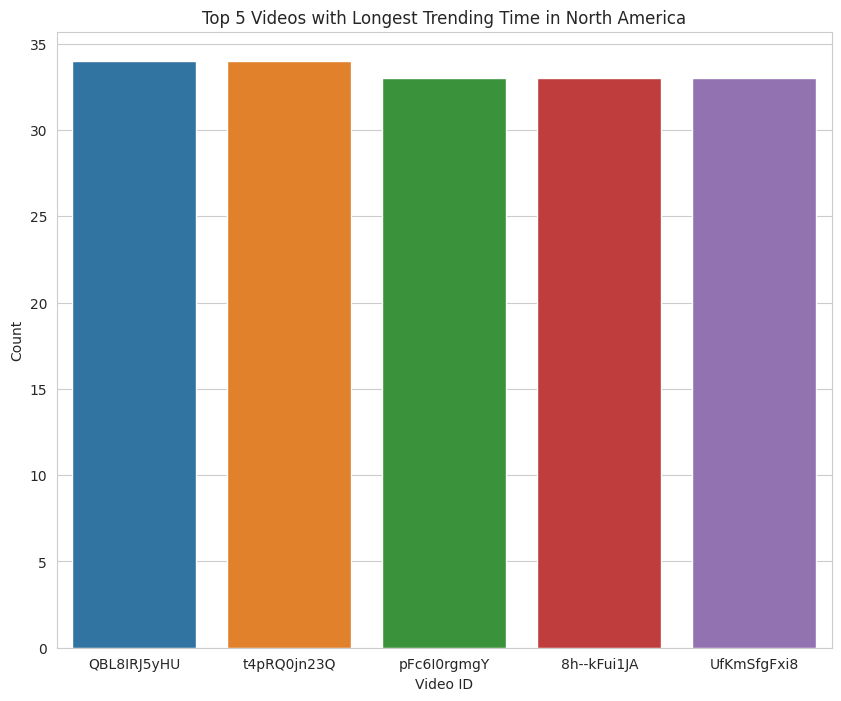

In [ ]:
#Top 5 Videos with Longest Trending Time 
df_NA_which_video_trended_maximum_days = df_NA_without_duplicates.sort_values(by = 'num_of_trending_days', ascending = False).head()
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
ax = sns.barplot(x=df_NA_which_video_trended_maximum_days['video_id'],y=df_NA_which_video_trended_maximum_days['num_of_trending_days'], data=df_NA_which_video_trended_maximum_days)
plt.xlabel("Video ID")
plt.ylabel("Count")
plt.title("Top 5 Videos with Longest Trending Time in North America")

Text(0.5, 1.0, "Boxplot of Videos' Number of Trending days")

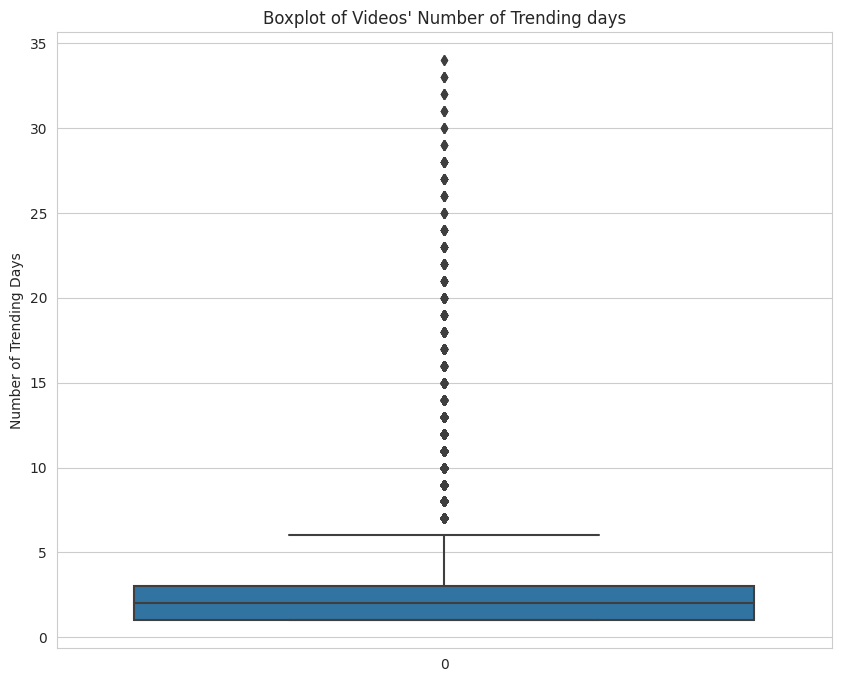

In [ ]:
#Boxplot of Videos' Number of Trending days
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
ax = sns.boxplot(df_NA_without_duplicates['num_of_trending_days'])
plt.ylabel("Number of Trending Days")
plt.title("Boxplot of Videos' Number of Trending days")

Text(0.5, 1.0, '5 Videos with the Longest Time to Become Trending Videos in North America')

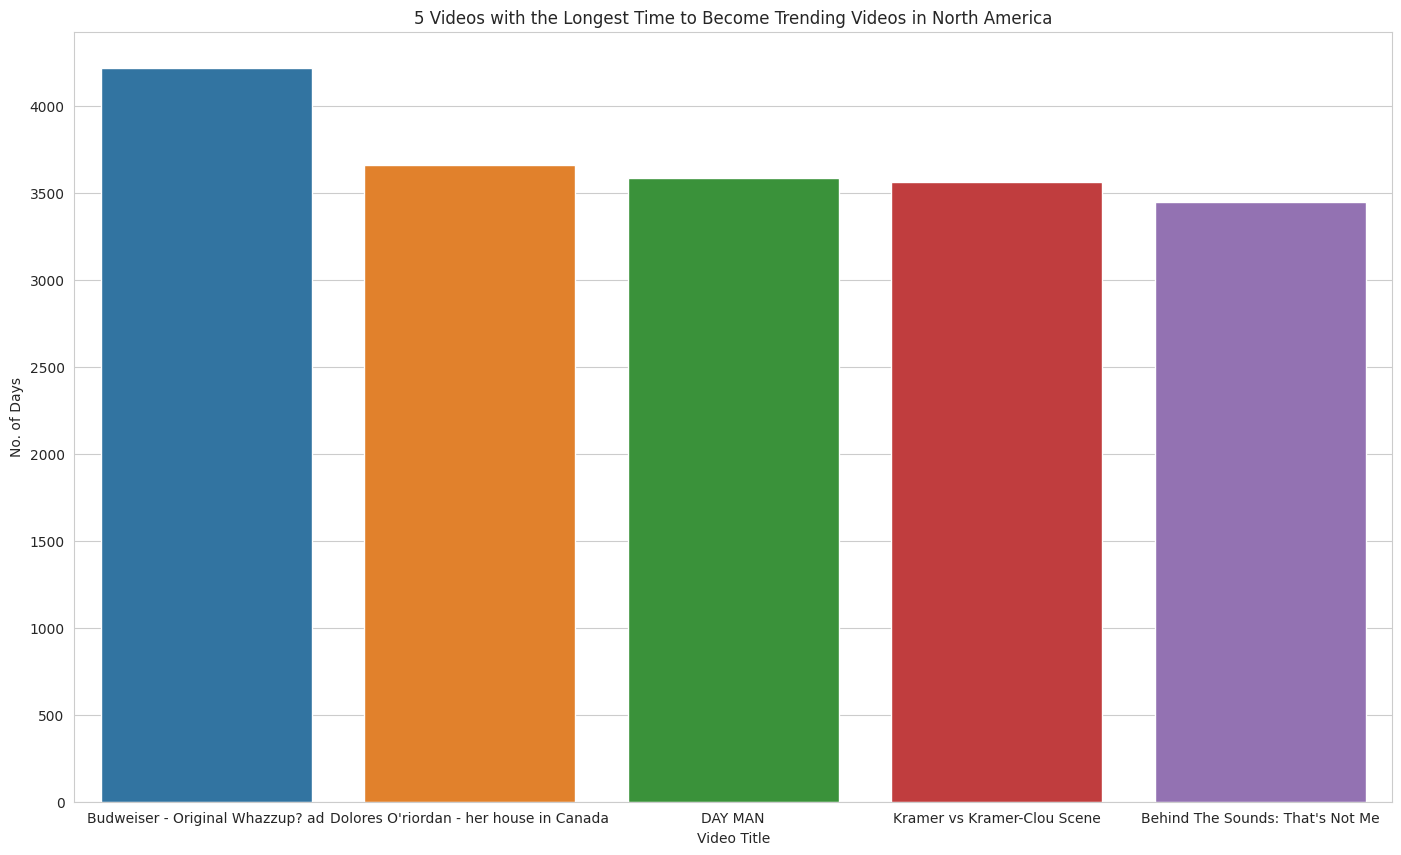

In [ ]:
#5 videos with the longest time to become trending videos after they were published
df_NA_without_duplicates['Days_taken_to_be_trending_video'] =df_NA_without_duplicates['trending_date'] - df_NA_without_duplicates['publish_date'] 
df_NA_without_duplicates['Days_taken_to_be_trending_video']= df_NA_without_duplicates['Days_taken_to_be_trending_video'] / np.timedelta64(1, 'D') + 1
NA_no_of_days_take_trend=df_NA_without_duplicates.sort_values(by='Days_taken_to_be_trending_video',ascending=False).head(5)

plt.figure(figsize=(17,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=NA_no_of_days_take_trend['title'],y=NA_no_of_days_take_trend['Days_taken_to_be_trending_video'], data=NA_no_of_days_take_trend)
plt.xlabel("Video Title")
plt.ylabel("No. of Days")
plt.title("5 Videos with the Longest Time to Become Trending Videos in North America")

Text(0.5, 1.0, 'Boxplot: Days Taken to Become Trending of All videos ')

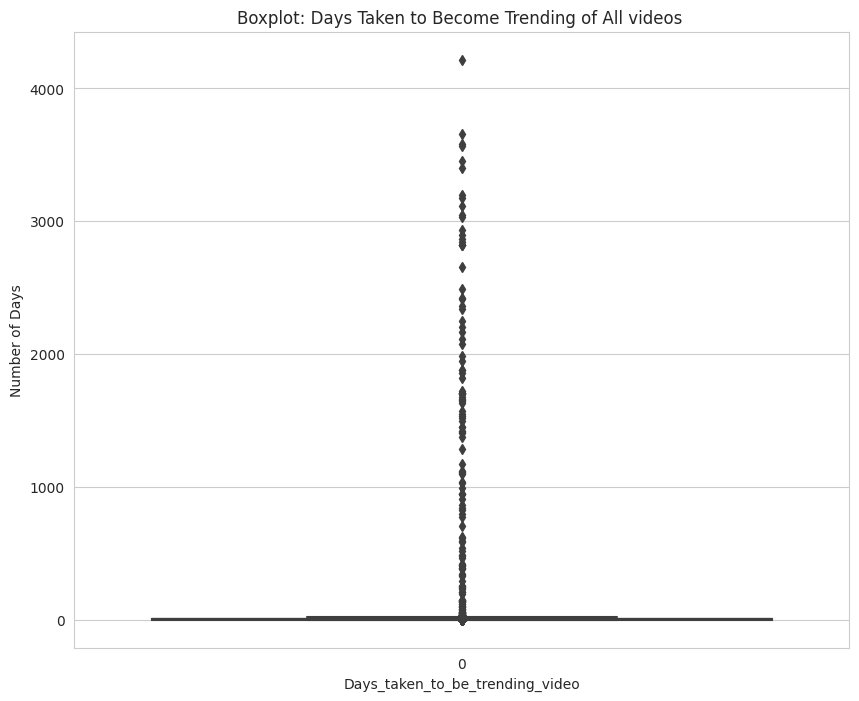

In [ ]:
#Boxplot: Days Taken to Become Trending of All videos 
plt.figure(figsize=(10,8))
sns.set_style("whitegrid")
sns.boxplot(df_NA_without_duplicates['num_of_trending_days'], whis =10)
sns.boxplot(df_NA_without_duplicates['Days_taken_to_be_trending_video'], whis =10)
plt.xlabel('Days_taken_to_be_trending_video')
plt.ylabel("Number of Days")
plt.title("Boxplot: Days Taken to Become Trending of All videos ")

Text(0.5, 1.0, 'Top 5 Trending Channel in North America')

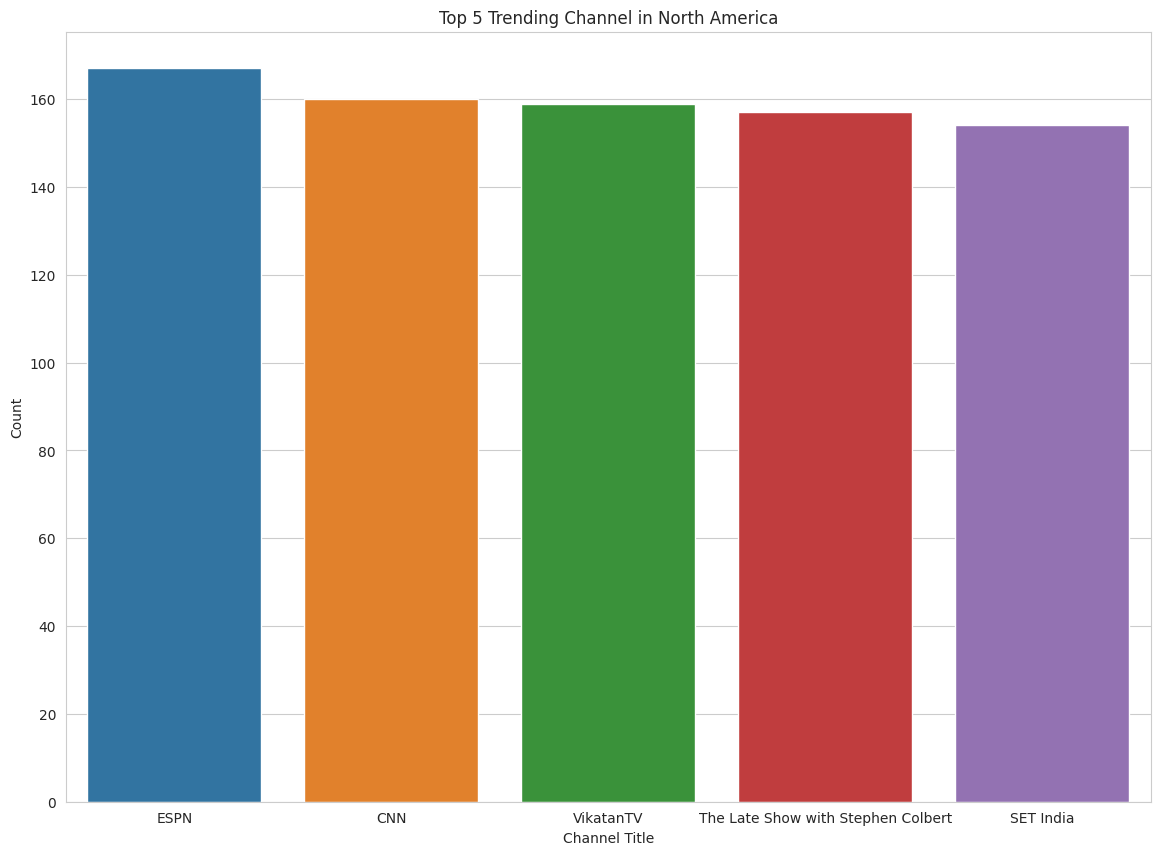

In [ ]:
NA_trending_channel=df_NA_without_duplicates.groupby(by=['channel_title'],as_index=False).count().sort_values(by='title',ascending=False).head(5)

plt.figure(figsize=(14,10))
sns.set_style("whitegrid")
ax = sns.barplot(x=NA_trending_channel['channel_title'],y=NA_trending_channel['video_id'], data=NA_trending_channel)
plt.xlabel("Channel Title")
plt.ylabel("Count")
plt.title("Top 5 Trending Channel in North America")

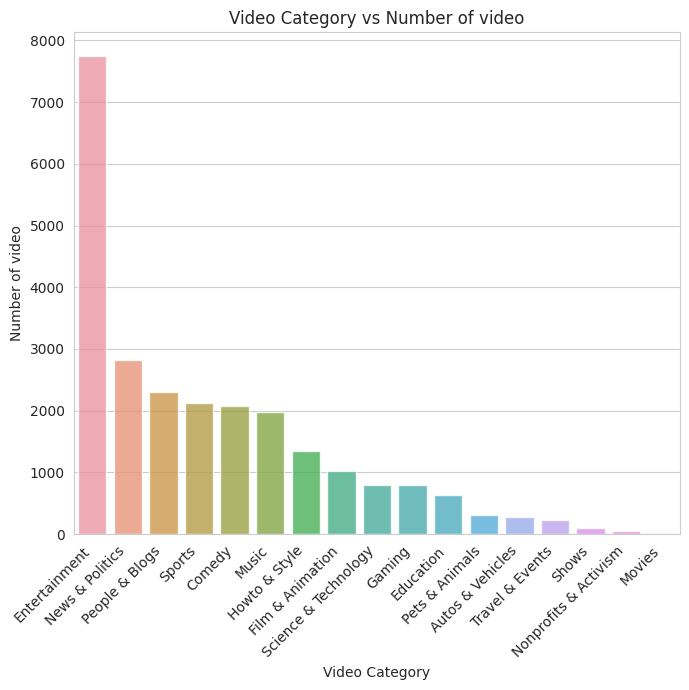

In [ ]:
#Barplot to observe the distribution of Trending Video Categories
count=df_NA_without_duplicates['category'].value_counts()
plt.figure(figsize=(7,7))
sns.set_style("whitegrid")
ax = sns.barplot(x =count.index, y =count.values, alpha=0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.title('Video Category vs Number of video')
plt.ylabel('Number of video')
plt.xlabel('Video Category')
plt.tight_layout()
plt.show()


False    24222
True       373
Name: comments_disabled, dtype: int64


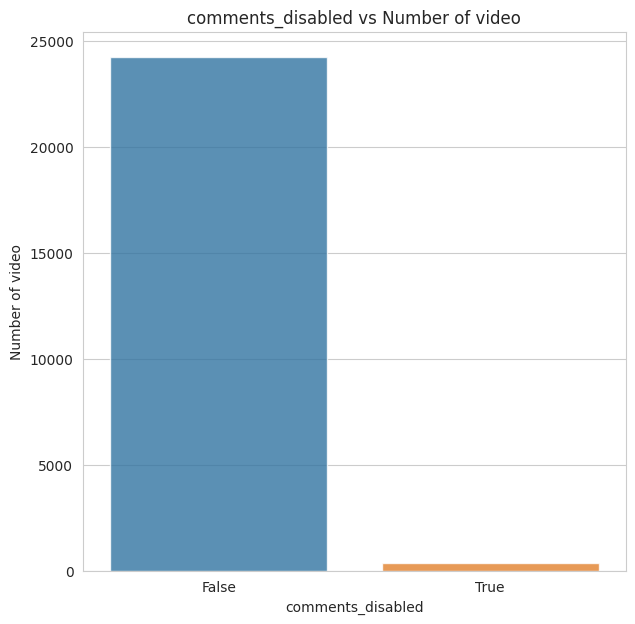

False    24458
True       137
Name: ratings_disabled, dtype: int64


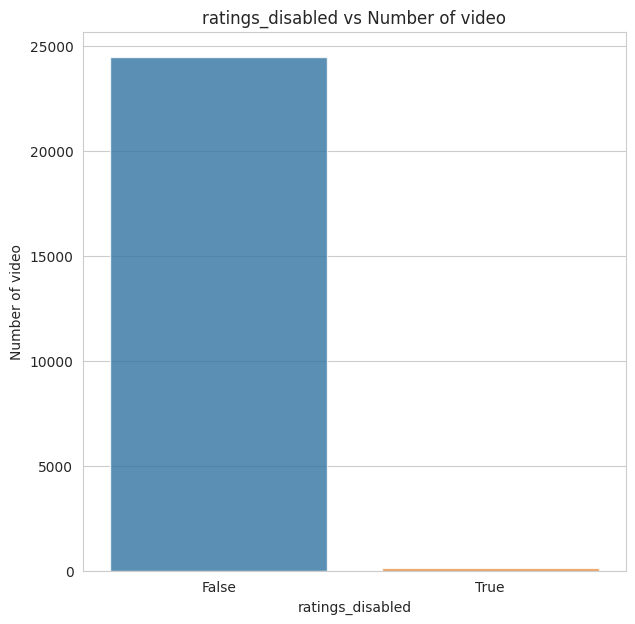

False    24580
True        15
Name: video_error_or_removed, dtype: int64


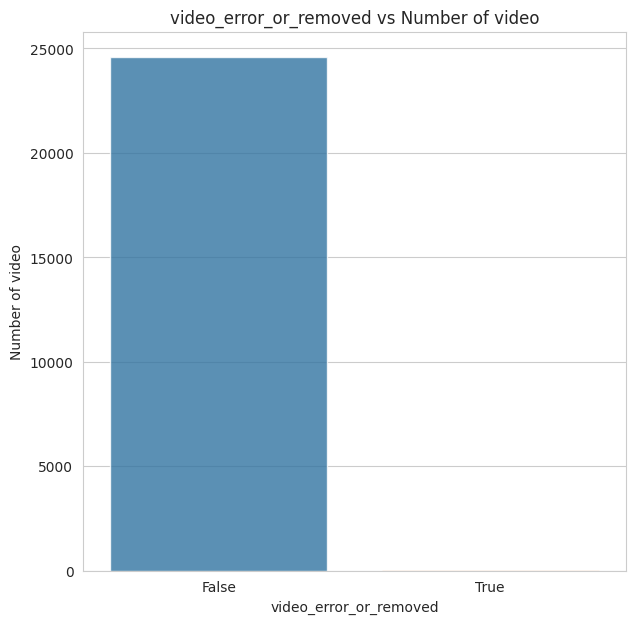

In [ ]:
#Check how many videos are comment disabled, rating disabled, or having errors or removed
for x in (['comments_disabled','ratings_disabled','video_error_or_removed']):
    count=df_NA_without_duplicates[x].value_counts()
    print(count)
    plt.figure(figsize=(7,7))
    sns.barplot(x =count.index, y =count.values, alpha=0.8)
    plt.title('{} vs Number of video'.format(x))
    plt.ylabel('Number of video')
    plt.xlabel('{}'.format(x))
    plt.show()

##Text Analysis

In [ ]:
#Define a Commmen Word Function
def wc(data, bgcolor, title):
  plt.figure(figsize = (100,100))
  wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
  wc.generate(' '.join(data))
  plt.title(title)
  plt.imshow(wc)
  plt.axis('off')

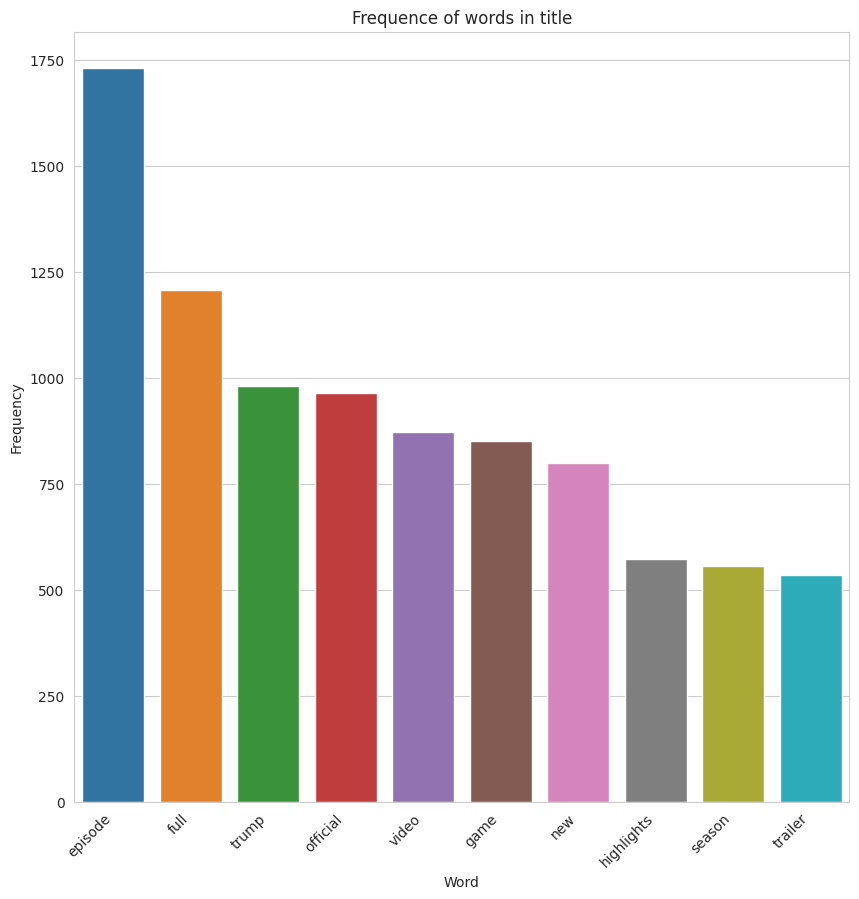

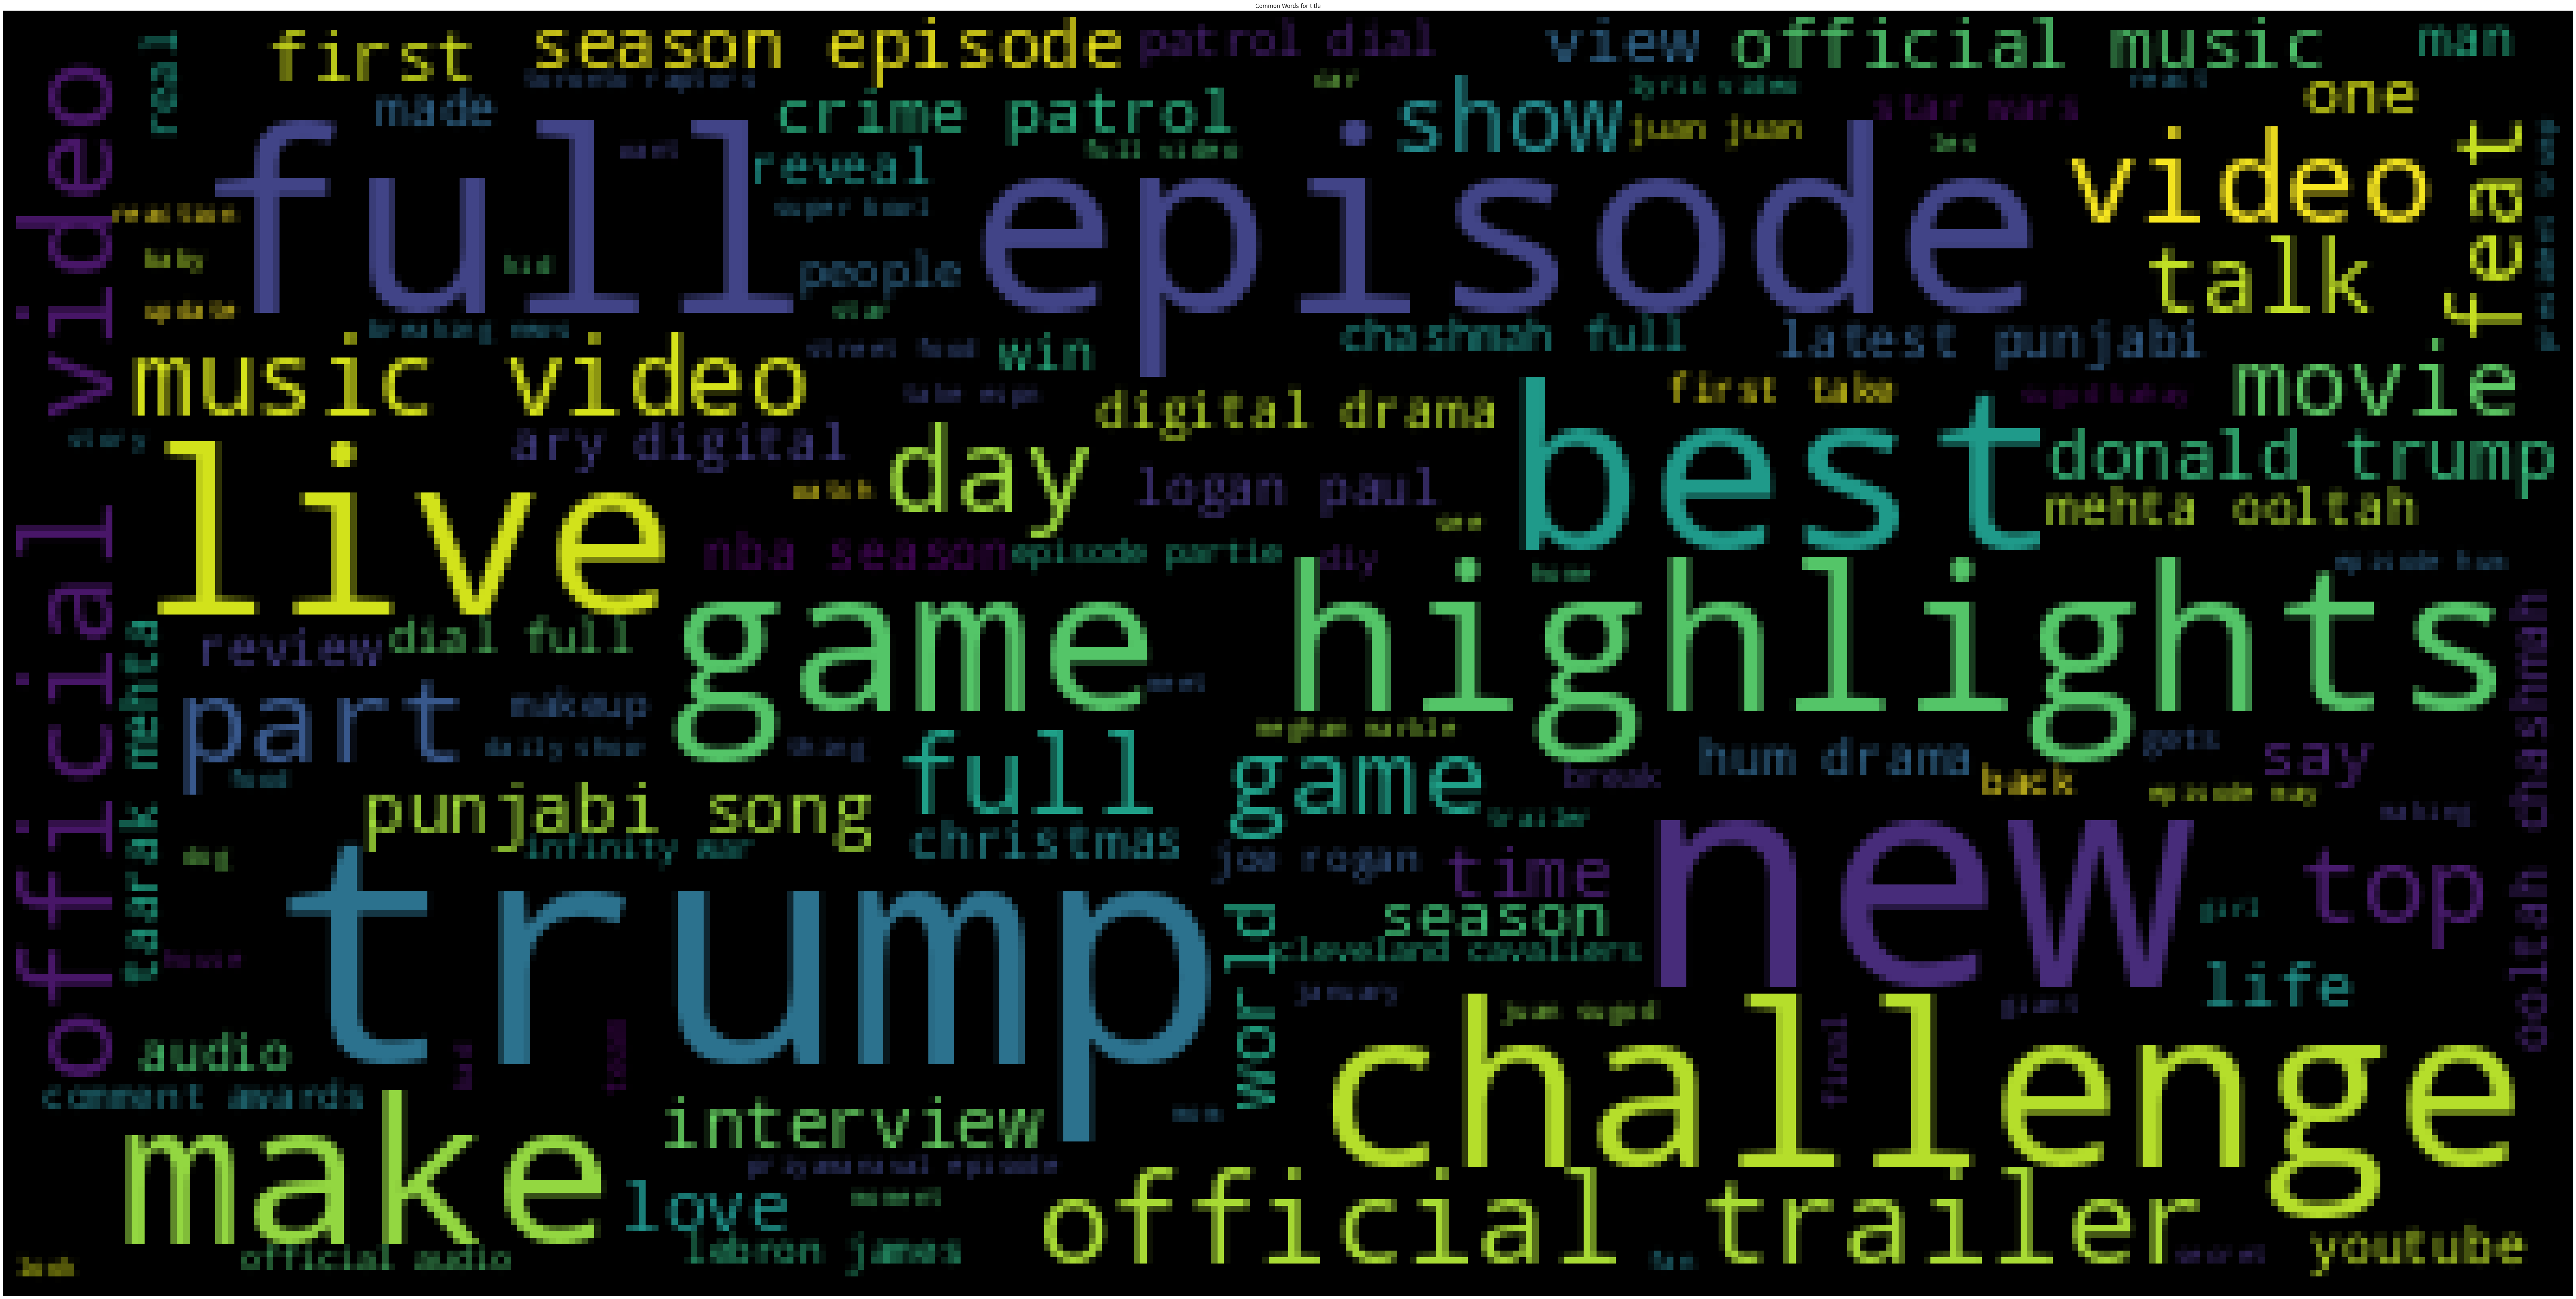

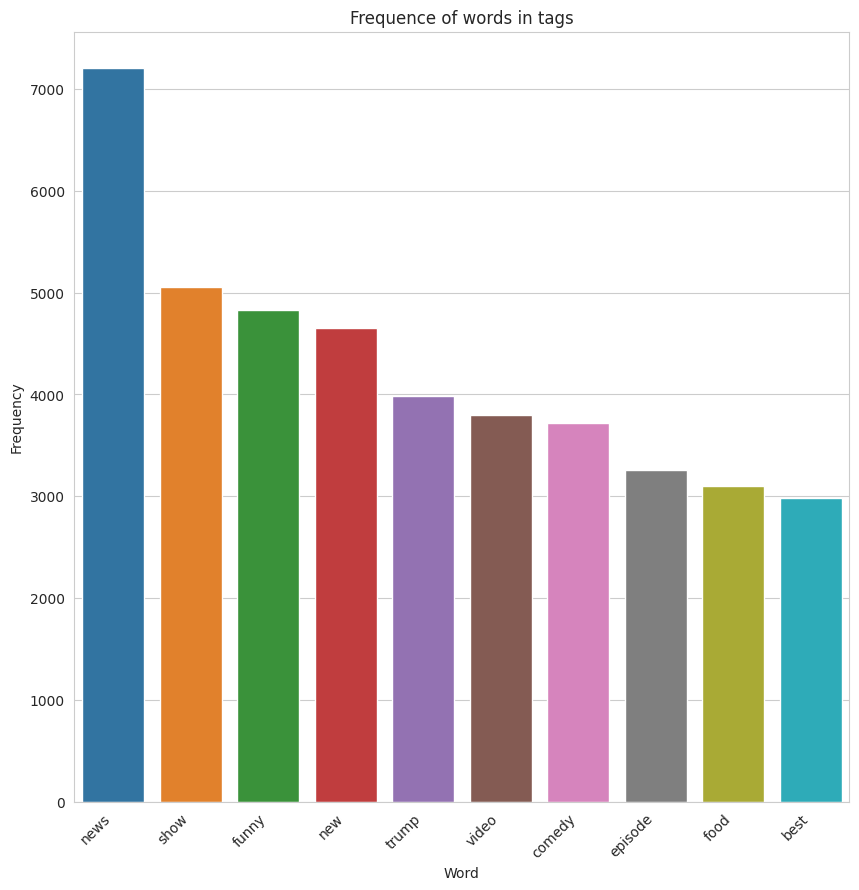

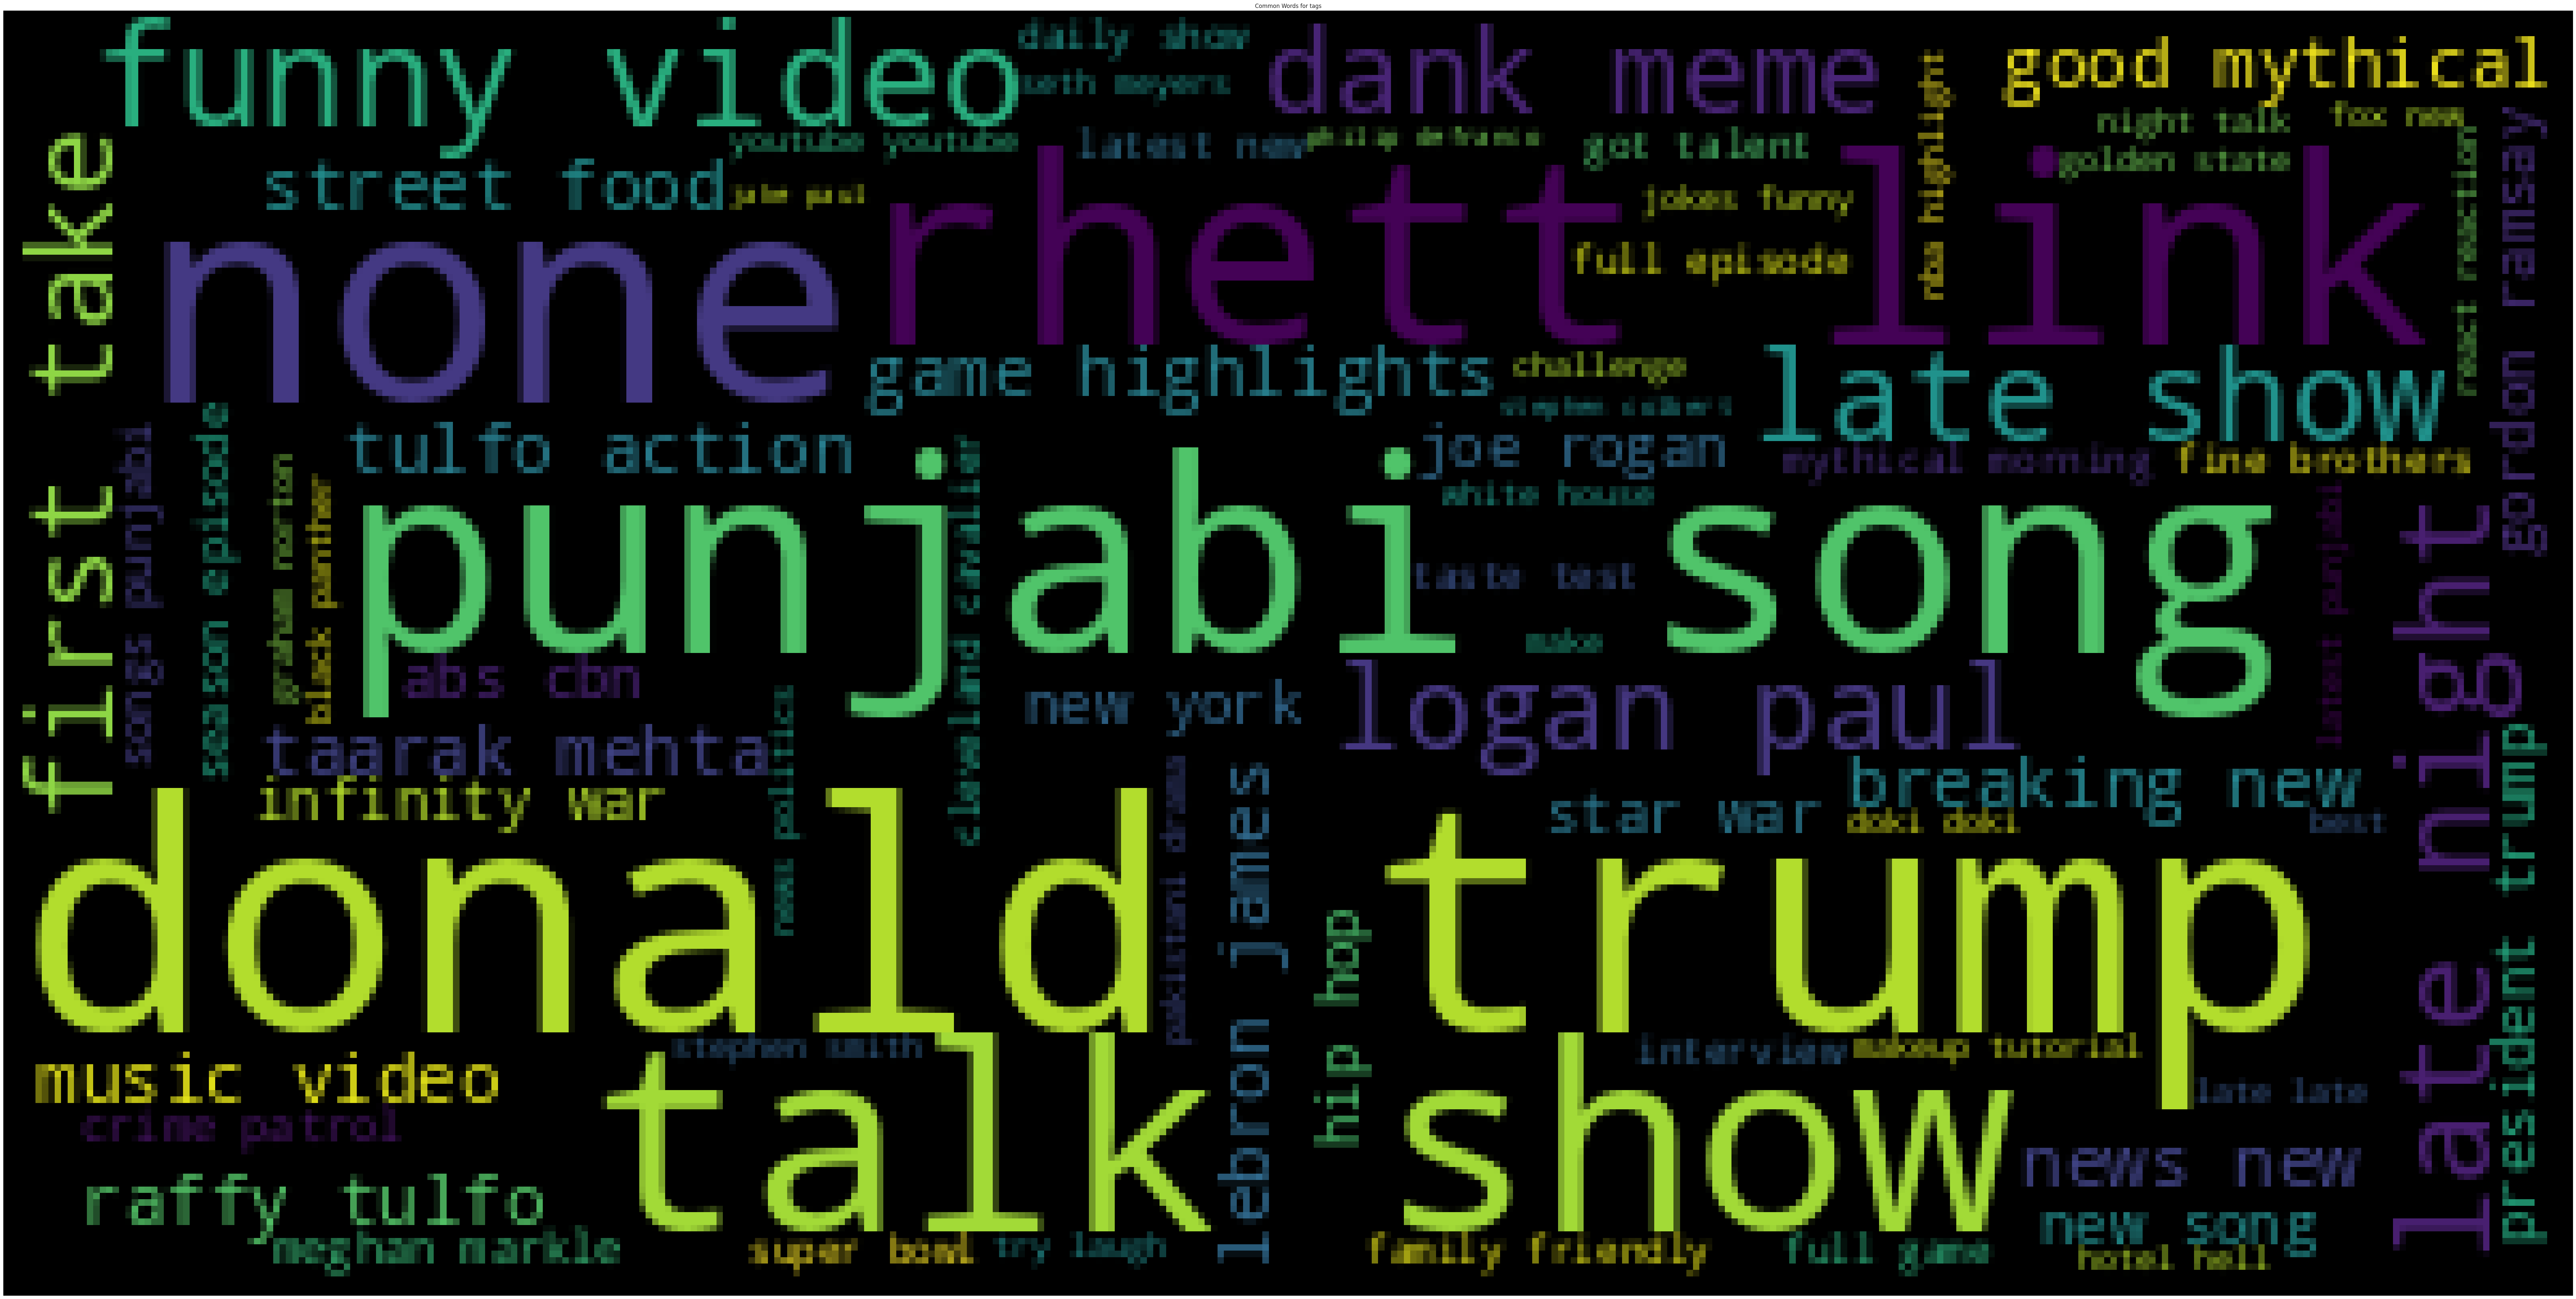

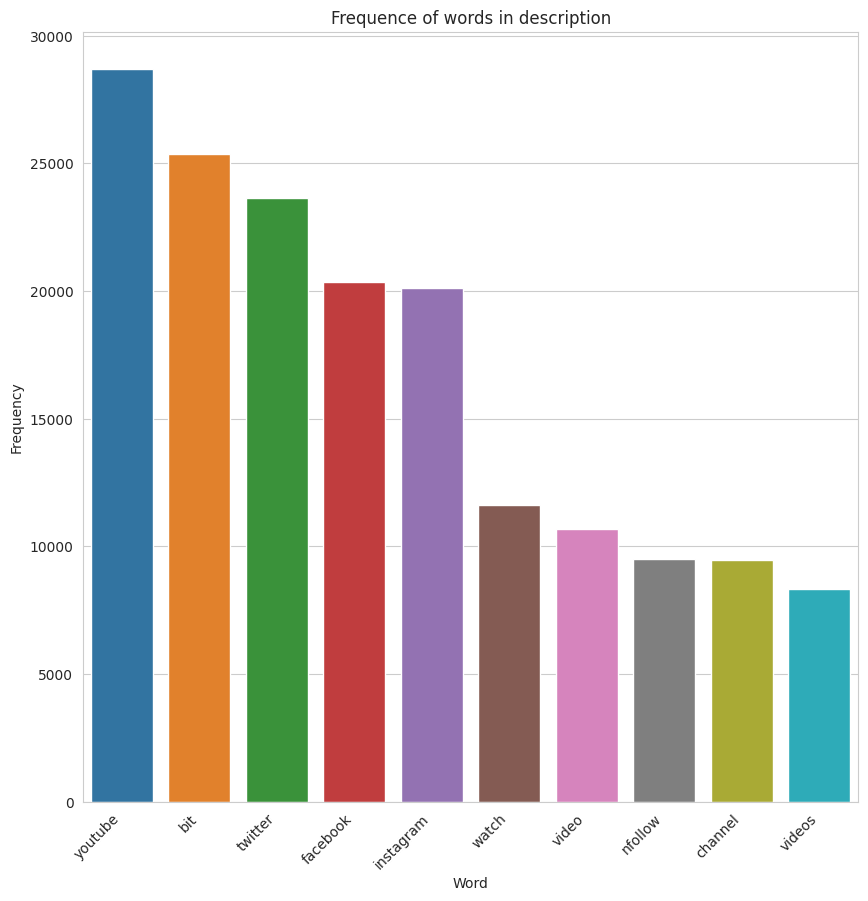

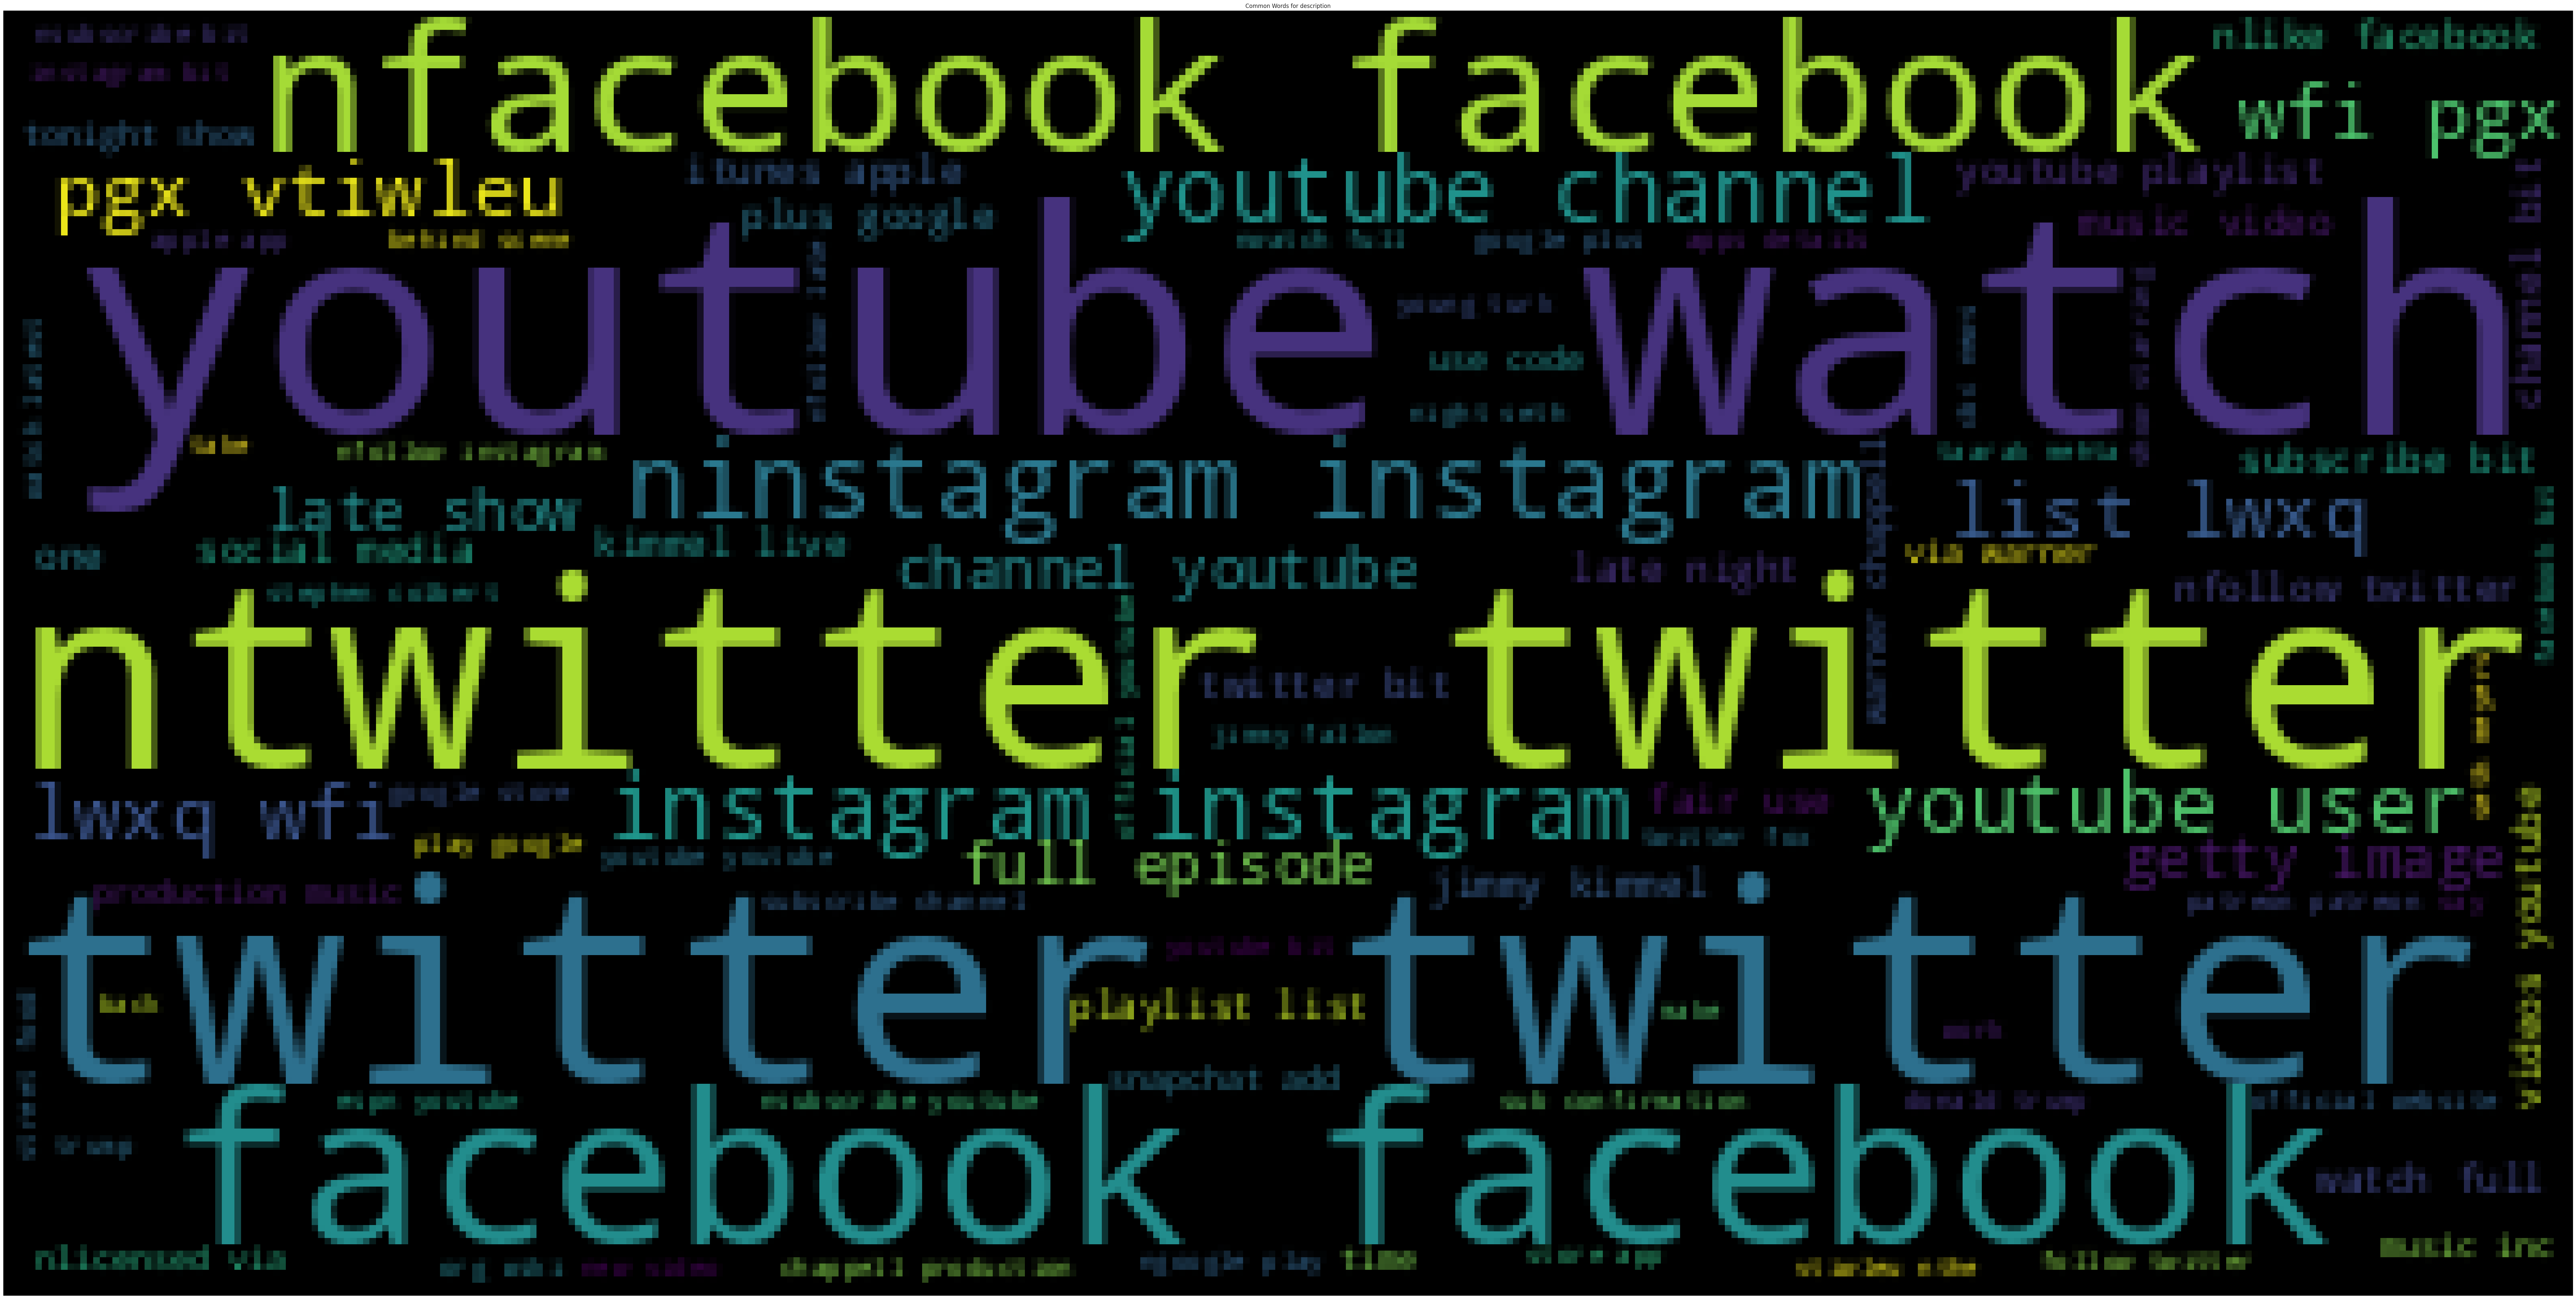

In [ ]:
top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

for x in ['title', 'tags', 'description']:
  a = df_NA_without_duplicates[x].str.lower().str.cat(sep=' ')

  # removes punctuation,numbers and returns list of words
  b = re.sub('[^A-Za-z]+', ' ', a)

  #remove all the stopwords from the text
  stop_words = list(get_stop_words('en'))         
  nltk_words = list(stopwords.words('english'))   
  stop_words.extend(nltk_words)
  stop_words.extend(['com', 'http', 'https', 'www', 'nhttps', 'goo', 'nhttp'])


  word_tokens = nltk.word_tokenize(b)
  filtered_sentence = [w for w in word_tokens if not w in stop_words]
  filtered_sentence = []
  for w in word_tokens:
      if w not in stop_words:
          filtered_sentence.append(w)

  # Remove characters which have length less than 2  
  without_single_chr = [word for word in filtered_sentence if len(word) > 2]

  # Remove numbers
  cleaned_data = [word for word in without_single_chr if not word.isnumeric()]        

  # Calculate frequency distribution
  word_dist = nltk.FreqDist(cleaned_data)
  rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

  plt.figure(figsize=(10,10))
  sns.set_style("whitegrid")
  ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(10))
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  plt.title('Frequence of words in {}'.format(x))


  wc(cleaned_data,'black','Common Words for {}'.format(x) )

##Sentiment analysis

Text(0.5, 1.0, 'Distribution of Title Sentiment Type')

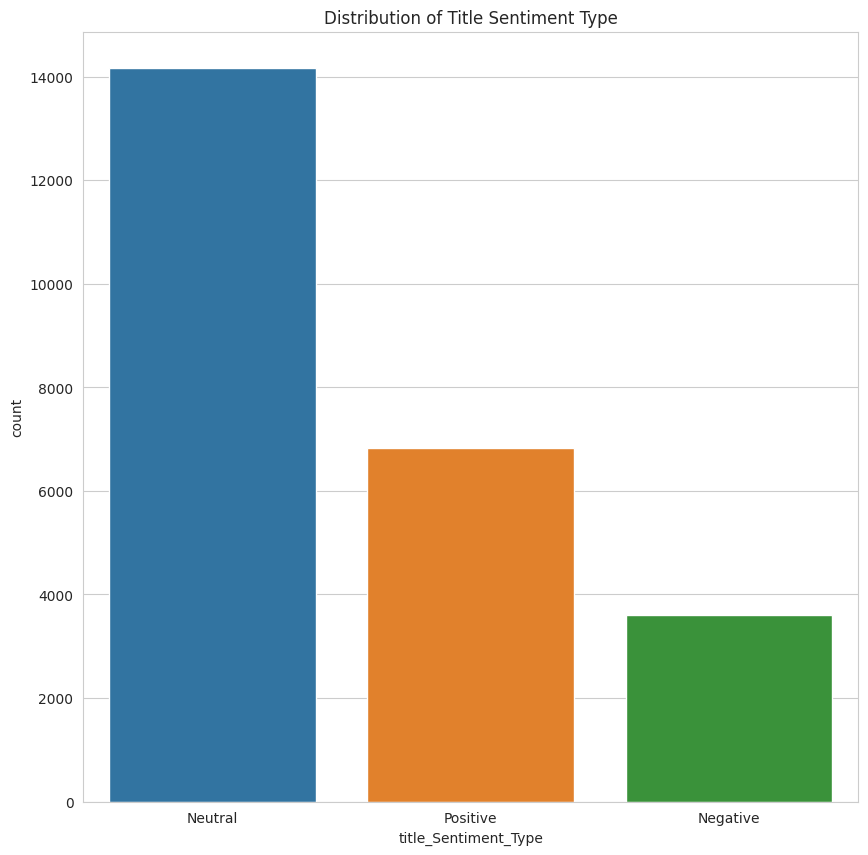

In [ ]:
bloblist_title = list()

df_NA_title_str=df_NA_without_duplicates['title']
for row in df_NA_title_str:
    blob = TextBlob(row)
    #Calculate the title's polarity and sentiment
    bloblist_title.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_NA_polarity_title = pd.DataFrame(bloblist_title, columns = ['sentence','sentiment','polarity'])

#Decide whether the title is positive or negative or netural
df_NA_polarity_title['title_Sentiment_Type'] = ''
df_NA_polarity_title['title_Sentiment_Type'] = np.where(df_NA_polarity_title['sentiment'] > 0, 'Positive', df_NA_polarity_title['title_Sentiment_Type'])
df_NA_polarity_title['title_Sentiment_Type'] = np.where(df_NA_polarity_title['sentiment'] == 0, 'Neutral', df_NA_polarity_title['title_Sentiment_Type'])
df_NA_polarity_title['title_Sentiment_Type'] = np.where(df_NA_polarity_title['sentiment'] < 0, 'Negative', df_NA_polarity_title['title_Sentiment_Type'])

#Add the title sentiment, polarity, and sentiment type to our big dataframe
df_NA_without_duplicates['title_Sentiment_Type'] = df_NA_polarity_title['title_Sentiment_Type'].tolist()
df_NA_without_duplicates['title_Sentiment'] = df_NA_polarity_title['sentiment'].tolist()
df_NA_without_duplicates['title_Polarity'] = df_NA_polarity_title['polarity'].tolist()

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="title_Sentiment_Type", data=df_NA_polarity_title)
plt.title('Distribution of Title Sentiment Type')

Text(0.5, 1.0, 'Distribution of Description Sentiment Type')

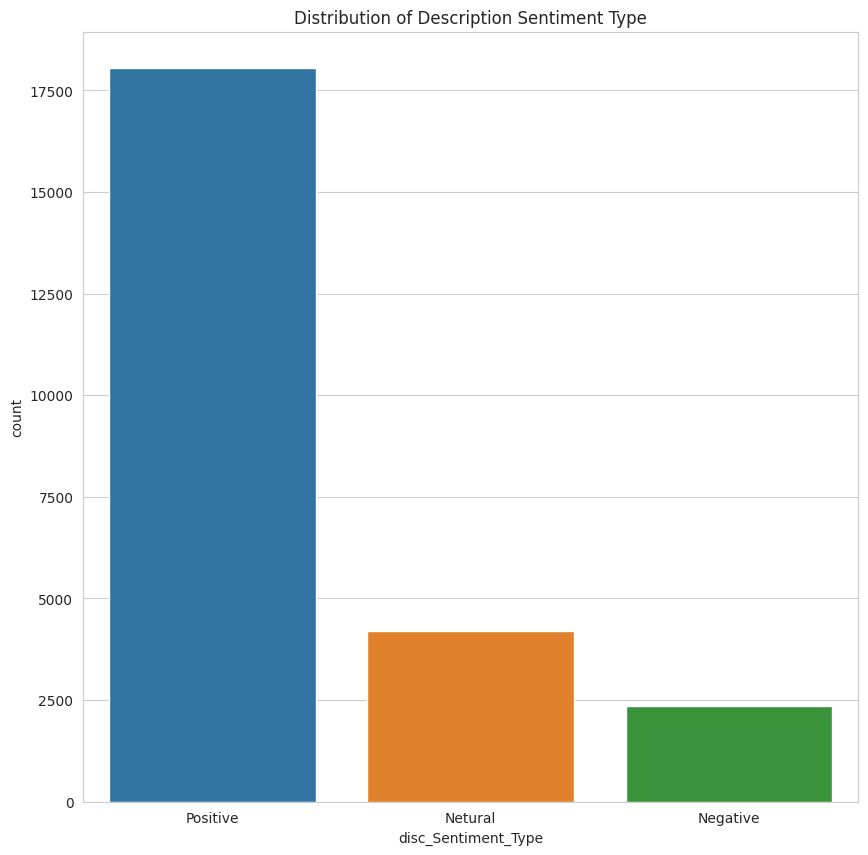

In [ ]:
bloblist_desc = list()

df_NA_descr_str=df_NA_without_duplicates['description'].astype(str)
for row in df_NA_descr_str:
    blob = TextBlob(row)
    #Calculate the Description's polarity and sentiment
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_NA_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])

#Decide whether the description is positive or negative or netural
df_NA_polarity_desc['disc_Sentiment_Type'] = ''
df_NA_polarity_desc['disc_Sentiment_Type'] = np.where(df_NA_polarity_desc['sentiment'] > 0, 'Positive', df_NA_polarity_desc['disc_Sentiment_Type'])
df_NA_polarity_desc['disc_Sentiment_Type'] = np.where(df_NA_polarity_desc['sentiment'] == 0, 'Netural', df_NA_polarity_desc['disc_Sentiment_Type'])
df_NA_polarity_desc['disc_Sentiment_Type'] = np.where(df_NA_polarity_desc['sentiment'] < 0, 'Negative', df_NA_polarity_desc['disc_Sentiment_Type'])

#Add the description sentiment, polarity, and sentiment type to our big dataframe
df_NA_without_duplicates['disc_Sentiment_Type'] = df_NA_polarity_desc['disc_Sentiment_Type'].tolist()
df_NA_without_duplicates['disc_Sentiment'] = df_NA_polarity_desc['sentiment'].tolist()
df_NA_without_duplicates['disc_Polarity'] = df_NA_polarity_desc['polarity'].tolist()

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="disc_Sentiment_Type", data=df_NA_polarity_desc)
plt.title('Distribution of Description Sentiment Type')

Text(0.5, 1.0, 'Distribution of Tags Sentiment Type')

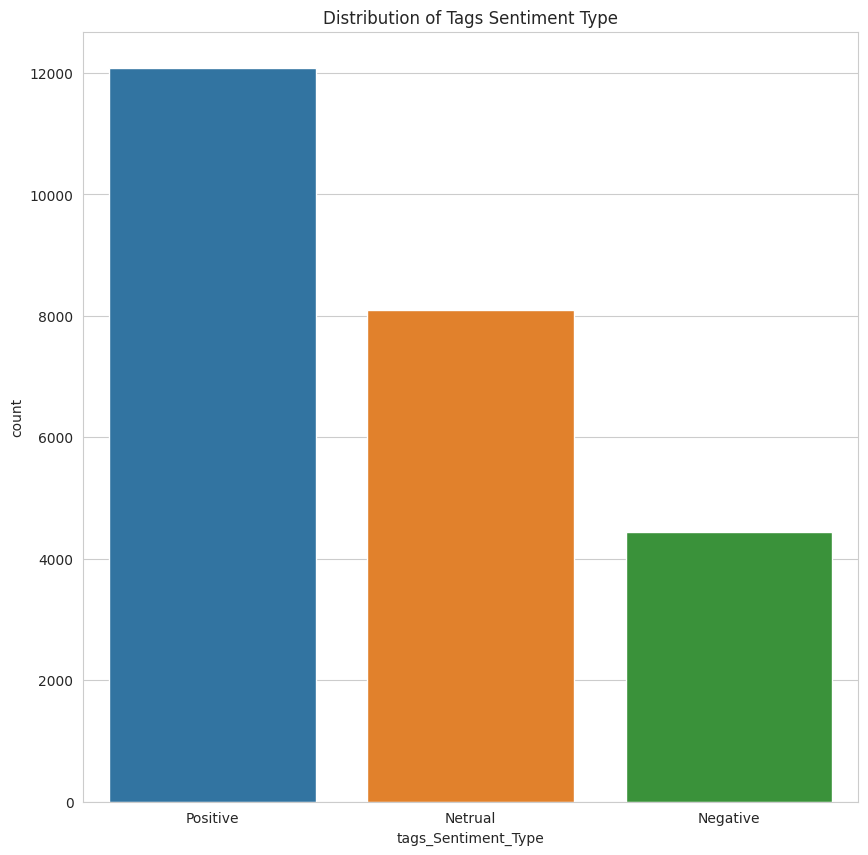

In [ ]:
bloblist_tags = list()

df_NA_tags_str=df_NA_without_duplicates['tags']
for row in df_NA_tags_str:
    blob = TextBlob(row)
    #Calculate the tags' polarity and sentiment
    bloblist_tags.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_NA_polarity_tags = pd.DataFrame(bloblist_tags, columns = ['sentence','sentiment','polarity'])
 
#Decide whether the tags are positive or negative or netural
df_NA_polarity_tags['tags_Sentiment_Type'] = ''
df_NA_polarity_tags['tags_Sentiment_Type'] = np.where(df_NA_polarity_tags['sentiment'] > 0, 'Positive', df_NA_polarity_tags['tags_Sentiment_Type'])
df_NA_polarity_tags['tags_Sentiment_Type'] = np.where(df_NA_polarity_tags['sentiment'] == 0, 'Netrual', df_NA_polarity_tags['tags_Sentiment_Type'])
df_NA_polarity_tags['tags_Sentiment_Type'] = np.where(df_NA_polarity_tags['sentiment'] < 0, 'Negative', df_NA_polarity_tags['tags_Sentiment_Type'])

#Add the tags' sentiment, polarity, and sentiment type to our big dataframe
df_NA_without_duplicates['tags_Sentiment_Type'] = df_NA_polarity_tags['tags_Sentiment_Type'].tolist()
df_NA_without_duplicates['tags_Sentiment'] = df_NA_polarity_tags['sentiment'].tolist()
df_NA_without_duplicates['tags_Polarity'] = df_NA_polarity_tags['polarity'].tolist()


plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="tags_Sentiment_Type", data=df_NA_polarity_tags)
plt.title('Distribution of Tags Sentiment Type')

#Feature Engineering

##Derive New Features

In [ ]:
rows_with_nan = df_NA_without_duplicates[df_NA_without_duplicates.isnull().any(axis=1)]
len(rows_with_nan)

731

In [ ]:
df_NA = df_NA_without_duplicates.dropna(how='any',axis=0)

In [ ]:
#Number of tags
tags=[x.count("|")+1 for x in df_NA["tags"]]
df_NA["Num_tags"]=tags

#length of desription
desc_len = []
for x in df_NA["description"]:
    if isinstance(x, float):
        desc_len.append(0)
    else:
        desc_len.append(len(x))
df_NA["desc_len"] = desc_len

#length of title
title_len=[len(x) for x in df_NA["title"]]
df_NA["len_title"]=title_len

#ratio of view/likes  upto 3 decimal
df_NA["Ratio_View_likes"]=round(df_NA["views"]/df_NA["likes"],3)
#ratio of view/dislikes  upto 3 decimal
df_NA["Ratio_View_dislikes"]=round(df_NA["views"]/df_NA["dislikes"],3)
#ratio of view/comment_count  upto 3 decimal
df_NA["Ratio_views_comment_count"]=round(df_NA["views"]/df_NA["comment_count"],3)
#ratio of likes/dislikes  upto 3 decimal
df_NA["Ratio_likes_dislikes"]=round(df_NA["likes"]/df_NA["dislikes"],3)

<ipython-input-25-dda210b4aa5f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NA["Num_tags"]=tags
<ipython-input-25-dda210b4aa5f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NA["desc_len"] = desc_len
<ipython-input-25-dda210b4aa5f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [ ]:
print("Maximum Ratio_View_likes: ", max(df_NA["Ratio_View_likes"]))
print("Maximum Ratio_View_dislikes: ", max(df_NA["Ratio_View_dislikes"]))
print("Maximum Ratio_views_comment_count: ", max(df_NA["Ratio_views_comment_count"]))
print("Maximum Ratio_likes_dislikes: ", max(df_NA["Ratio_likes_dislikes"]))
print("Minimum Ratio_View_likes: ", min(df_NA["Ratio_View_likes"]))
print("Minimum Ratio_View_dislikes: ", min(df_NA["Ratio_View_dislikes"]))
print("Minimum Ratio_views_comment_count: ", min(df_NA["Ratio_views_comment_count"]))
print("Minimum Ratio_likes_dislikes: ", min(df_NA["Ratio_likes_dislikes"]))

Maximum Ratio_View_likes:  inf
Maximum Ratio_View_dislikes:  inf
Maximum Ratio_views_comment_count:  inf
Maximum Ratio_likes_dislikes:  inf
Minimum Ratio_View_likes:  3.472
Minimum Ratio_View_dislikes:  5.125
Minimum Ratio_views_comment_count:  3.283
Minimum Ratio_likes_dislikes:  0.0


In [ ]:
#Replace the infinite values with the mode of the column

df_NA=df_NA.replace([np.inf, -np.inf], np.nan)
# Loop through all columns in the DataFrame
for col in ["Ratio_View_likes", "Ratio_View_dislikes", "Ratio_views_comment_count", "Ratio_likes_dislikes"]:
    # Calculate the mode of the column
    mode_val = df_NA[df_NA[col].notnull()][col].mode().values[0]
    # Replace NaN values in the column with the mode value
    df_NA[col].fillna(value=mode_val, inplace=True)

In [ ]:
def ohe(data, labels):

  assert isinstance(labels, list), "must be list of columns to OHE"
  oh_enc = OneHotEncoder()
  oh_enc.fit(data[labels])
  dummies = pd.DataFrame(oh_enc.transform(data[labels]).todense(),
  columns=oh_enc.get_feature_names_out(),
  index = data.index)

  return data.join(dummies), oh_enc.get_feature_names_out()

In [ ]:
df_NA['publish_weekday'] = df_NA['publish_date'].dt.day_name()
df_NA['publish_month'] = df_NA['publish_date'].dt.month
df_NA['publish_year'] = df_NA['publish_date'].dt.year
df_NA['publish_hour'] = df_NA['publish_time'].apply(lambda x: x.hour)
#onehot encoding on categorical variables Weekday and Country
df_NA, ohe_publish_weekday = ohe(df_NA, ['publish_weekday'])
df_NA, ohe_publish_month = ohe(df_NA, ['publish_month'])
df_NA, ohe_publish_year = ohe(df_NA, ['publish_year'])
df_NA, ohe_country = ohe(df_NA, ['Country'])

##Data Transformation

<ipython-input-30-7bed547fd422>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g1 = sns.distplot(df_NA['views'])
<ipython-input-30-7bed547fd422>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g2 = sns.distplot(df_NA['likes'],color='green')
<ipython-input-30-7bed547fd422>:13: UserWarning: 

`distplot` is a deprecated 

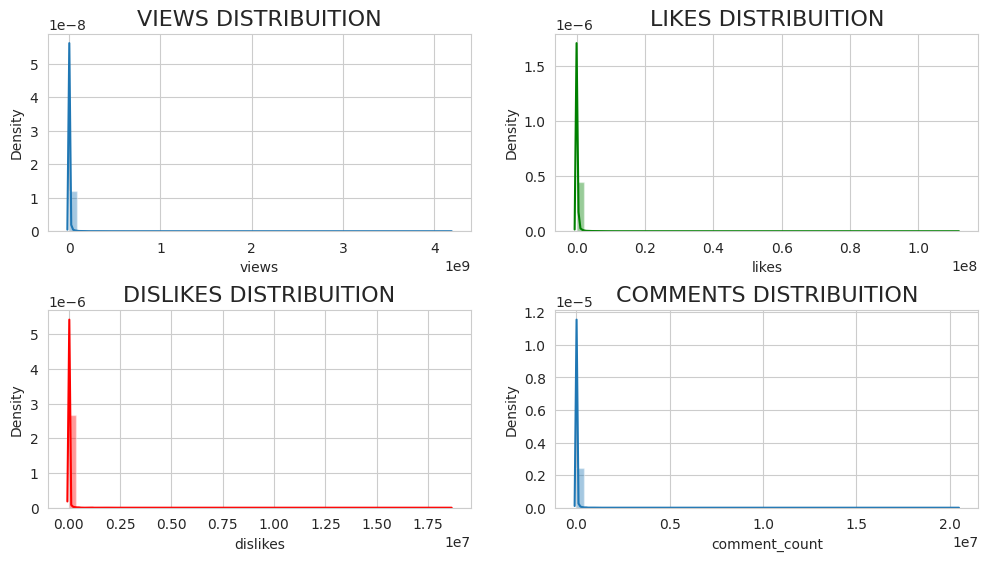

In [ ]:
#Observe the distribution of views, likes, dislikes, and comment counts
plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(df_NA['views'])
g1.set_title("VIEWS DISTRIBUITION", fontsize=16)

plt.subplot(222)
g2 = sns.distplot(df_NA['likes'],color='green')
g2.set_title('LIKES DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(df_NA['dislikes'], color='red')
g3.set_title("DISLIKES DISTRIBUITION", fontsize=16)

plt.subplot(224)
g4 = sns.distplot(df_NA['comment_count'])
g4.set_title("COMMENTS DISTRIBUITION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

<ipython-input-31-68d48f3ed10f>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g1 = sns.distplot(df_NA['views_log'])
<ipython-input-31-68d48f3ed10f>:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g2 = sns.distplot(df_NA['likes_log'],color='green')
<ipython-input-31-68d48f3ed10f>:18: UserWarning: 

`distplot` is a d

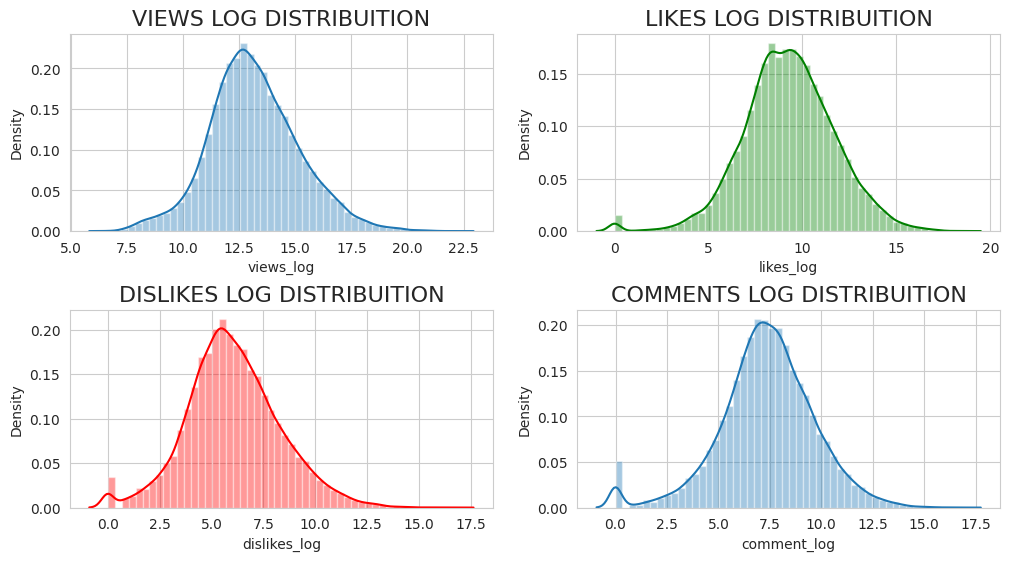

In [ ]:
#Take the log transformation on views, likes, dislikes, and comment counts to make it approxmately normal
df_NA['likes_log'] = np.log(df_NA['likes'] + 1 )
df_NA['views_log'] = np.log(df_NA['views'] )
df_NA['dislikes_log'] = np.log(df_NA['dislikes'] + 1)
df_NA['comment_log'] = np.log(df_NA['comment_count'] + 1)

plt.figure(figsize = (12,6))

plt.subplot(221)
g1 = sns.distplot(df_NA['views_log'])
g1.set_title("VIEWS LOG DISTRIBUITION", fontsize=16)

plt.subplot(222)
g2 = sns.distplot(df_NA['likes_log'],color='green')
g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(df_NA['dislikes_log'], color='r')
g3.set_title("DISLIKES LOG DISTRIBUITION", fontsize=16)

plt.subplot(224)
g4 = sns.distplot(df_NA['comment_log'])
g4.set_title("COMMENTS LOG DISTRIBUITION", fontsize=16)

plt.subplots_adjust(wspace = 0.2, hspace = 0.4,top = 0.9)

plt.show()

In [ ]:
print("views_log (Statistics Description):", df_NA[['views_log']].describe())
print("likes_log (Statistics Description):", df_NA[['likes_log']].describe())
print("comment_log (Statistics Description):", df_NA[['comment_log']].describe())
print("dislikes_log (Statistics Description):", df_NA[['dislikes_log']].describe())


views_log (Statistics Description):           views_log
count  23864.000000
mean      13.163233
std        1.989334
min        6.617403
25%       11.870381
50%       13.022840
75%       14.389062
max       22.151245
likes_log (Statistics Description):           likes_log
count  23864.000000
mean       9.274642
std        2.412212
min        0.000000
25%        7.774436
50%        9.250234
75%       10.820698
max       18.527693
comment_log (Statistics Description):         comment_log
count  23864.000000
mean       7.348607
std        2.310538
min        0.000000
25%        6.079933
50%        7.379632
75%        8.772145
max       16.831385
dislikes_log (Statistics Description):        dislikes_log
count  23864.000000
mean       6.058086
std        2.236202
min        0.000000
25%        4.624973
50%        5.918894
75%        7.417580
max       16.737559


In [ ]:
#Tranform all of 0 in the views, likes, dislikes, comment count to 0.1
columns_to_replace = ['views', 'likes', 'dislikes', 'comment_count']
for col in columns_to_replace:
    df_NA[col] = df_NA[col].replace(0, 0.1)

In [ ]:
# Check which data transformation works the best for other variables in the dataframe

# transforms = {'linear': lambda x: x, 'log': np.log, 'square': np.square, 'cube': lambda x: x**3, 'sqrt': np.sqrt, 'cubic root': lambda x: x**(1/3)}

# cols = ['num_of_trending_days',
#        'Days_taken_to_be_trending_video',
#        'title_Sentiment', 'title_Polarity',
#        'disc_Sentiment', 'disc_Polarity', 'tags_Sentiment', 
#         'tags_Polarity', 'Num_tags', 'desc_len', 'len_title',
#         'Ratio_View_likes', 'Ratio_View_dislikes',
#        'Ratio_views_comment_count', 'Ratio_likes_dislikes', 
#         ] #'likes', 'dislikes', 'comment'
# corrs = []
# for col in cols:
#   for t in transforms:
#     f = transforms[t]
#     cor = np.corrcoef(f(df_NA[col]), df_NA['views_log'])[0, 1]
#     corrs.append([col, t, cor])
# corrs

transforms = {
    'linear': lambda x: x, 
    'log': lambda x: np.log(x) if x > 0 else np.nan, 
    'square': np.square, 
    'cube': lambda x: x**3, 
    'sqrt': np.sqrt, 
    'cubic root': lambda x: x**(1/3)
}

cols = [
    'num_of_trending_days','Days_taken_to_be_trending_video','title_Sentiment', 
    'title_Polarity','disc_Sentiment', 'disc_Polarity', 'tags_Sentiment','tags_Polarity', 'Num_tags', 'desc_len', 'len_title','Ratio_View_likes', 'Ratio_View_dislikes',       'Ratio_views_comment_count', 'Ratio_likes_dislikes'
] 

best_corrs = []
for col in cols:
    best_corr = 0
    best_transform = None
    for t in transforms:
        f = transforms[t]
        transformed_col = df_NA[col].apply(f)
        views_log = df_NA.loc[transformed_col.index, 'views_log']
        corr = np.corrcoef(transformed_col, views_log)[0, 1]
        print("{} transformation ({}): {}".format(t, col, corr))
        if abs(corr) > abs(best_corr):
            best_corr = corr
            best_transform = t
    best_corrs.append([col, best_transform, best_corr])

for corr in best_corrs:
    print("\n {} (Best transformation: {}, correlation): {}".format(corr[0], corr[1], corr[2]))



linear transformation (num_of_trending_days): 0.6644484549513906
log transformation (num_of_trending_days): 0.7287137856718714
square transformation (num_of_trending_days): 0.5169376139481122
cube transformation (num_of_trending_days): 0.3885309963016691
sqrt transformation (num_of_trending_days): 0.7138681939576144
cubic root transformation (num_of_trending_days): 0.7227117383022452
linear transformation (Days_taken_to_be_trending_video): -0.04097487287781869
log transformation (Days_taken_to_be_trending_video): 0.00421268522120437
square transformation (Days_taken_to_be_trending_video): -0.029700677770889146
cube transformation (Days_taken_to_be_trending_video): -0.022414373028138437
sqrt transformation (Days_taken_to_be_trending_video): -0.04247537875613657
cubic root transformation (Days_taken_to_be_trending_video): -0.03503614994850093
linear transformation (title_Sentiment): -0.003648699005419839
log transformation (title_Sentiment): nan
square transformation (title_Sentiment): 0

In [ ]:
#Transform the variables
df_NA['num_of_trending_days_log'] = np.log(df_NA['num_of_trending_days'])
df_NA['Days_taken_to_be_trending_video_sqrt'] = np.sqrt(df_NA['Days_taken_to_be_trending_video'])
df_NA['title_Sentiment_cbrt'] = np.cbrt(df_NA['title_Sentiment'])
df_NA['title_Polarity_sq'] = np.square(df_NA['title_Polarity'])
df_NA['disc_Sentiment_cbrt'] = np.cbrt(df_NA['disc_Sentiment'])
df_NA['disc_Polarity_cbrt'] = np.cbrt(df_NA['disc_Polarity'])
df_NA['tags_Sentiment_cbrt'] = np.cbrt(df_NA['tags_Sentiment'])
df_NA['tags_Polarity_sqrt'] = np.sqrt(df_NA['tags_Polarity'])
df_NA['Num_tags_log'] = np.log(df_NA['Num_tags'])
df_NA['desc_len_log'] = np.log(df_NA['desc_len'])
df_NA['len_title_log'] = np.log(df_NA['len_title'])
df_NA['Ratio_View_likes_log'] = np.log(df_NA['Ratio_View_likes'])
df_NA['Ratio_View_dislikes_log'] = np.log(df_NA['Ratio_View_dislikes'])
df_NA['Ratio_views_comment_count_log'] = np.log(df_NA['Ratio_views_comment_count'])


In [ ]:
len(df_NA.columns)

91

##Run the Decision Tree and Wrapper to make feature selection for Models

In [ ]:
df_NA_copy = df_NA.copy()
#We drop the columns which were transformed in previous cell
df_NA_copy.drop(['num_of_trending_days', 'Days_taken_to_be_trending_video', 
                 'title_Sentiment', 'title_Polarity', 'disc_Sentiment', 'disc_Polarity', 
                 'tags_Sentiment', 'tags_Polarity', 'Num_tags', 'desc_len', 'len_title', 
                 'Ratio_View_likes', 'Ratio_View_dislikes', 'Ratio_views_comment_count', 
                 'views', 'likes', 'dislikes','comment_count'], axis=1,inplace=True)

#Select only numerical columns
numerical_columns = df_NA_copy.select_dtypes(include=['number']).columns
df_NA_copy = df_NA_copy[numerical_columns]

In [ ]:
#We put all of columns related to videos' preformance evaluations into a separate dataframe
df_evl_metric = df_NA_copy[['likes_log', 'views_log', 'dislikes_log', 'comment_log','Ratio_View_likes_log',
       'Ratio_View_dislikes_log', 'Ratio_views_comment_count_log', 'Ratio_likes_dislikes']]

In [ ]:
# df_NA_copy = df_NA_copy.drop(['likes_log', 'dislikes_log', 'comment_log','Ratio_View_likes_log',
#        'Ratio_View_dislikes_log', 'Ratio_views_comment_count_log', 'Ratio_likes_dislikes'], axis=1)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split


y = df_NA_copy['views_log'].values

X = df_NA_copy.drop(['views_log','likes_log', 'dislikes_log', 'comment_log','Ratio_View_likes_log',
       'Ratio_View_dislikes_log', 'Ratio_views_comment_count_log', 'Ratio_likes_dislikes'], axis = 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42)

# Create the RFE object and compute a cross-validated score
rfe = RFE(estimator=tree, n_features_to_select=15, step=1)

# Fit the RFE object to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]

print("Selected Features:")
print(selected_features)

Selected Features:
Index(['publish_month', 'publish_hour', 'publish_weekday_Friday', 'Country_US',
       'num_of_trending_days_log', 'Days_taken_to_be_trending_video_sqrt',
       'title_Sentiment_cbrt', 'title_Polarity_sq', 'disc_Sentiment_cbrt',
       'disc_Polarity_cbrt', 'tags_Sentiment_cbrt', 'tags_Polarity_sqrt',
       'Num_tags_log', 'desc_len_log', 'len_title_log'],
      dtype='object')


## Run the Heatmap

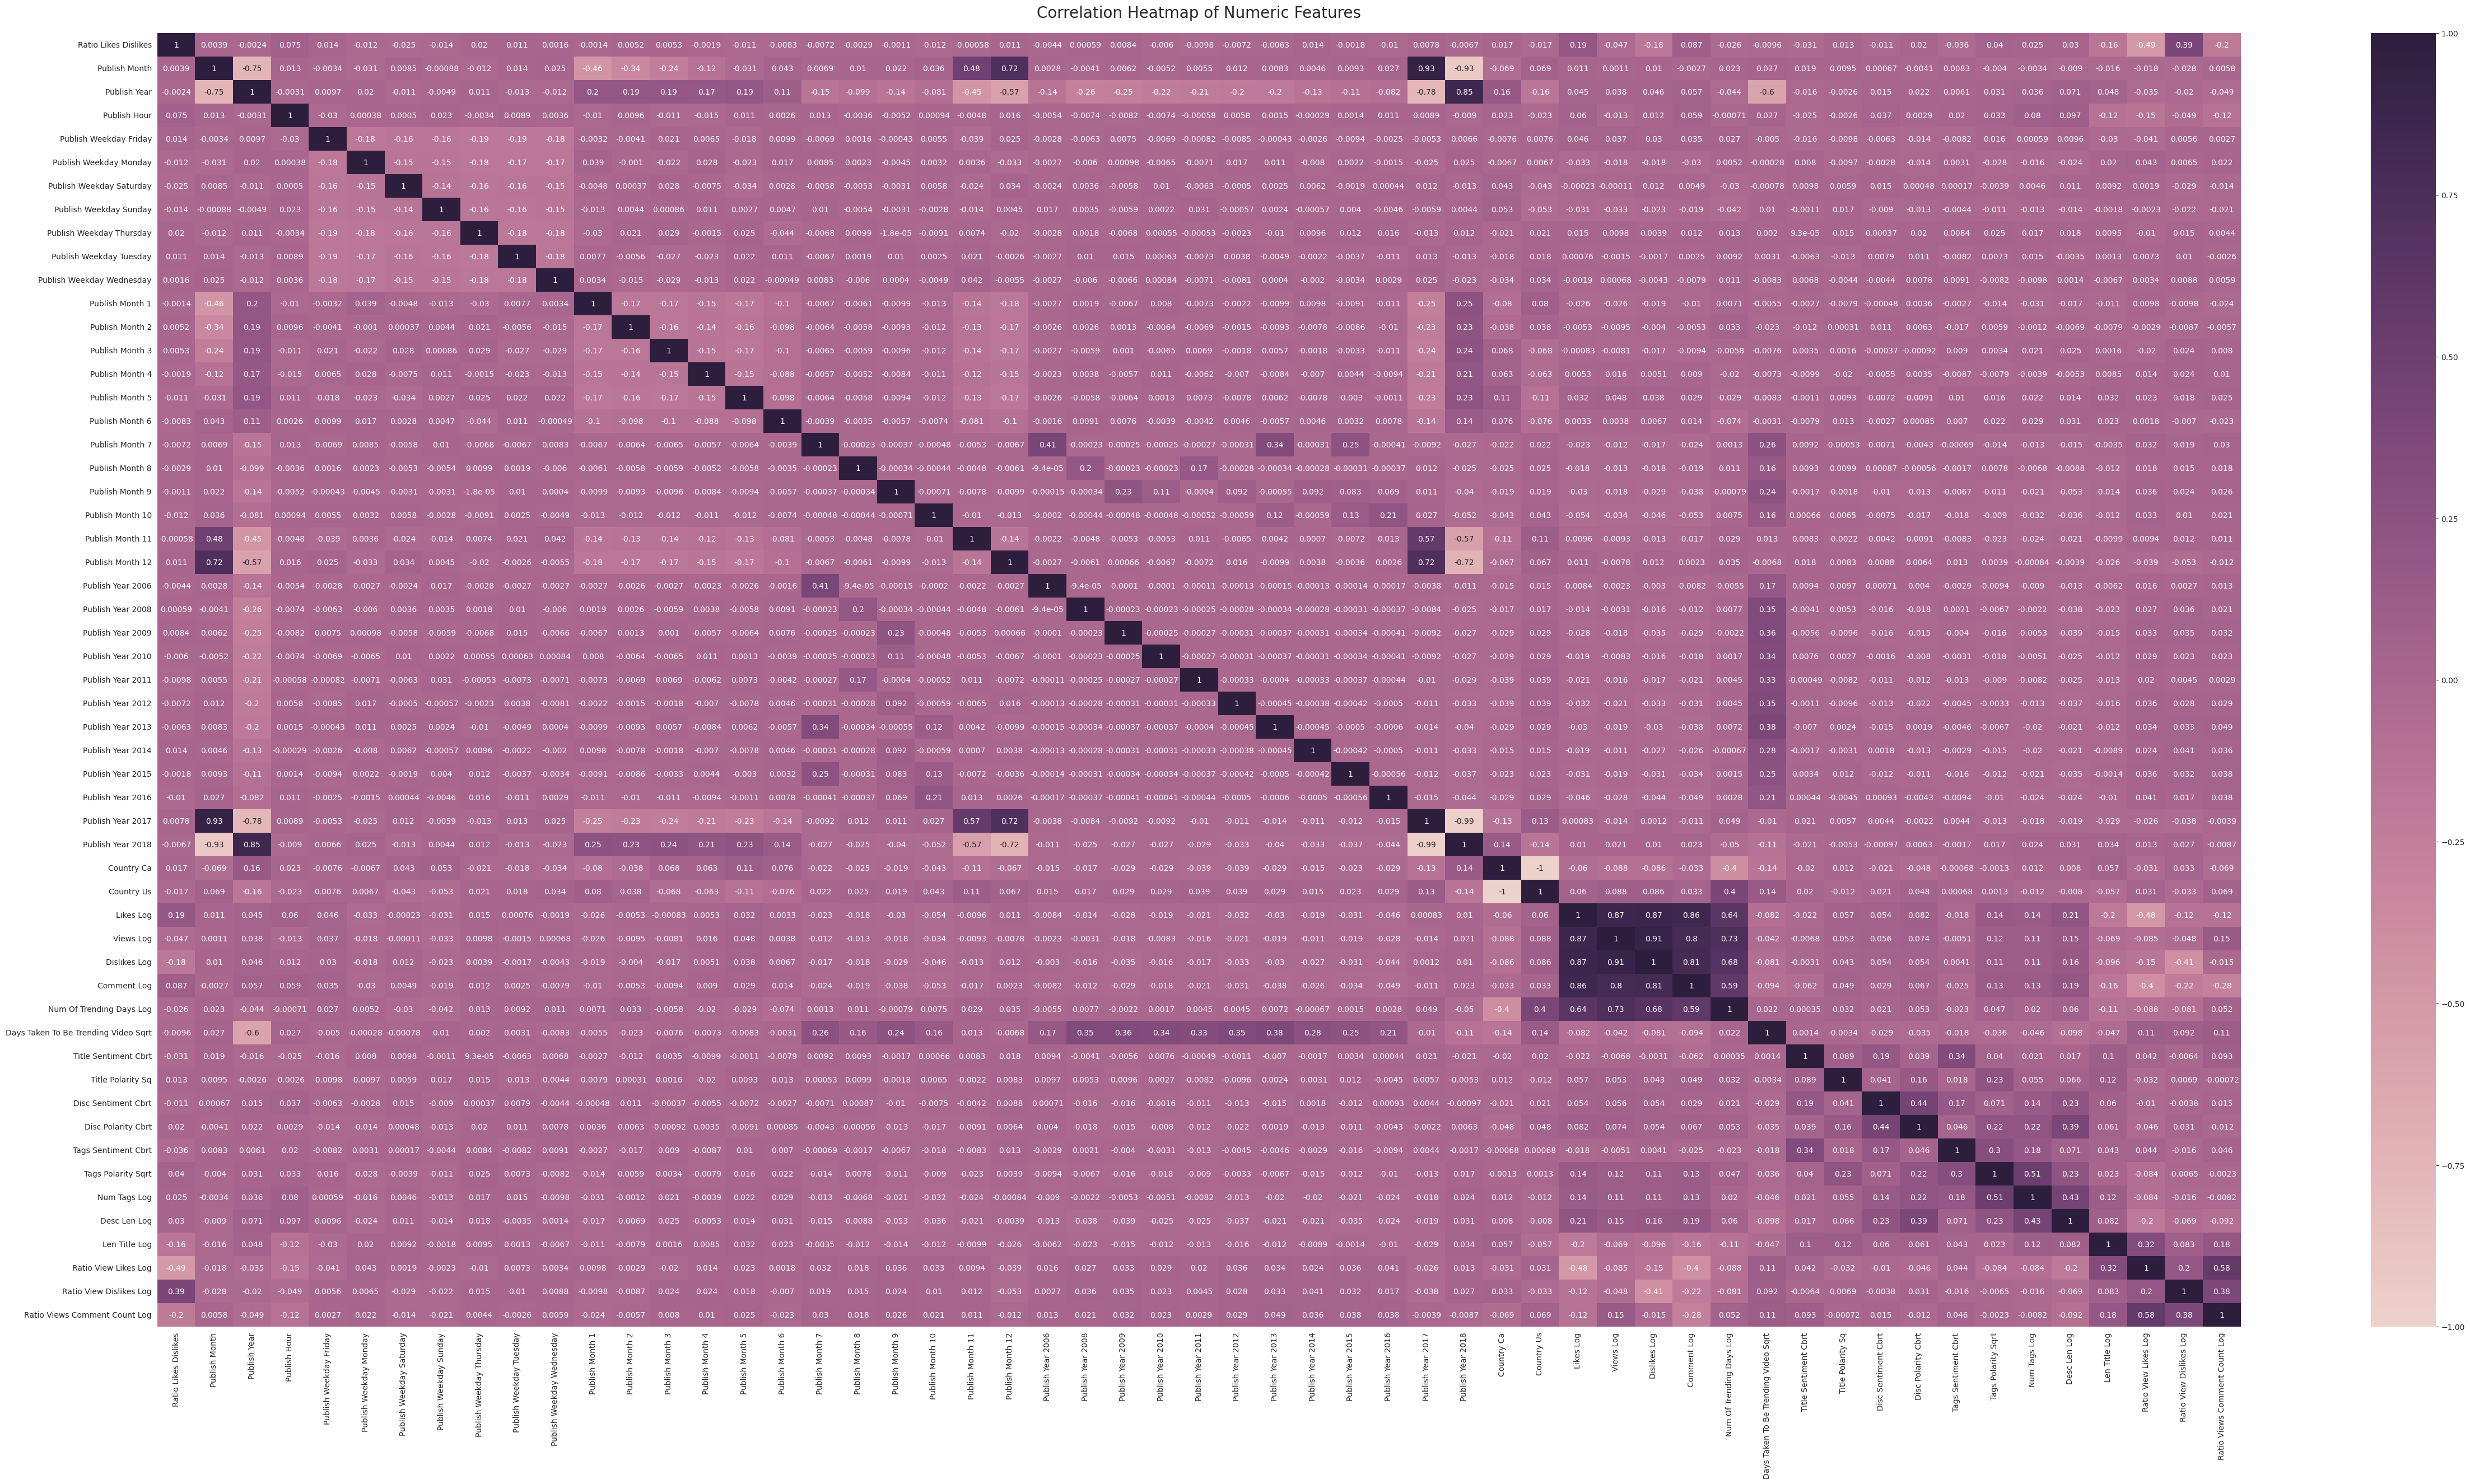

In [ ]:
#The heatmap with all of features with evaluation features


h_labels = [x.replace('_', ' ').title() for x in 
            list(df_NA_copy.select_dtypes(include=['number', 'bool']).columns.values)]

fig, ax = plt.subplots(figsize=(60,30))
ax.set_title("Correlation Heatmap of Numeric Features", fontsize=20, pad=20)
_ = sns.heatmap(df_NA_copy.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

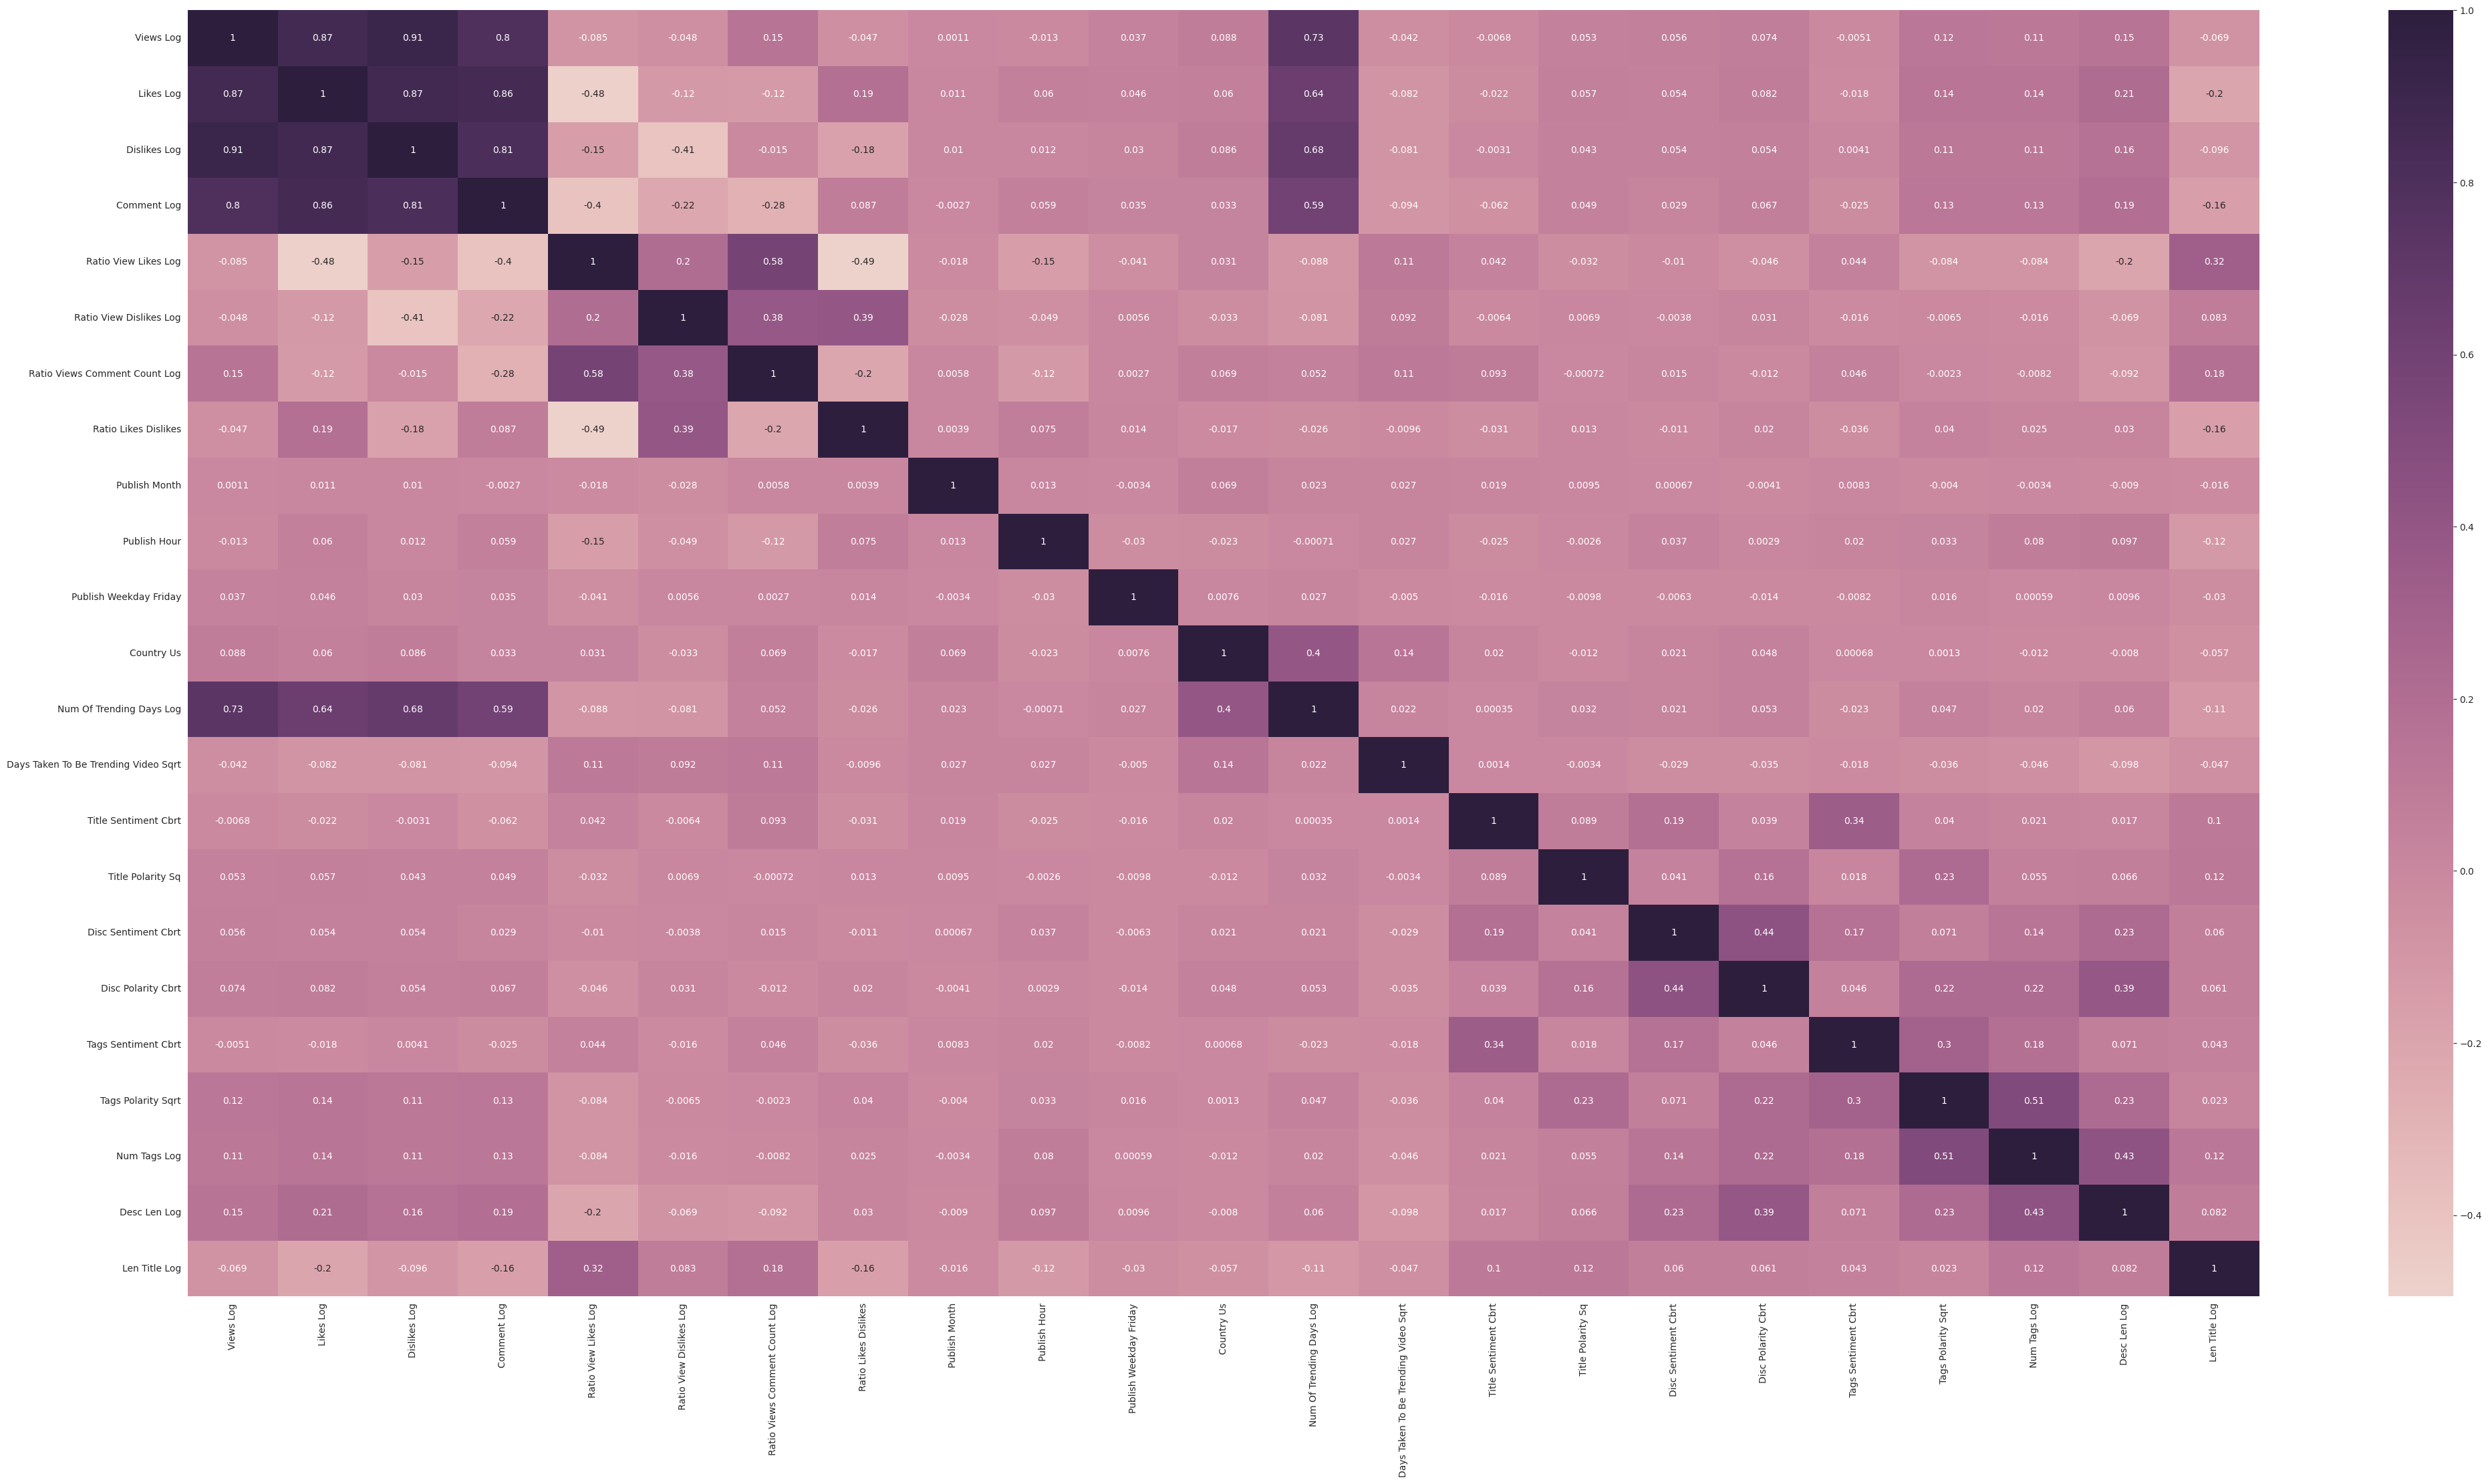

In [ ]:
#The heatmap with the selected features and evaluation features
df_NA_select = df_NA_copy[['views_log', 'likes_log', 'dislikes_log', 'comment_log','Ratio_View_likes_log',
       'Ratio_View_dislikes_log', 'Ratio_views_comment_count_log', 'Ratio_likes_dislikes',
      'publish_month', 'publish_hour', 'publish_weekday_Friday', 'Country_US',
      'num_of_trending_days_log', 'Days_taken_to_be_trending_video_sqrt',
       'title_Sentiment_cbrt', 'title_Polarity_sq', 'disc_Sentiment_cbrt',
       'disc_Polarity_cbrt', 'tags_Sentiment_cbrt', 'tags_Polarity_sqrt',
       'Num_tags_log', 'desc_len_log', 'len_title_log']]


h_labels = [x.replace('_', ' ').title() for x in 
            list(df_NA_select.select_dtypes(include=['number', 'bool']).columns.values)]

ax.set_title("Correlation Heatmap of Selected Features (from Decision Tree)", fontsize=20, pad=20)
fig, ax = plt.subplots(figsize=(50,25))
_ = sns.heatmap(df_NA_select.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

#Train & Test(Evaluation) Splitting with 80:20 Ratio



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df_evl = df_NA_select[['views_log', 'likes_log', 'dislikes_log', 'comment_log','Ratio_View_likes_log',
       'Ratio_View_dislikes_log', 'Ratio_views_comment_count_log', 'Ratio_likes_dislikes']]

df_NA_view=df_NA_select.drop(['views_log', 'likes_log', 'dislikes_log', 'comment_log','Ratio_View_likes_log',
       'Ratio_View_dislikes_log', 'Ratio_views_comment_count_log', 'Ratio_likes_dislikes'],axis=1,inplace=False)


train, test,y_train_ft,y_test_ft=train_test_split(df_NA_view, df_evl, test_size=0.2,shuffle=False)
print(train.shape,test.shape,y_train_ft.shape,y_test_ft.shape)

(19091, 15) (4773, 15) (19091, 8) (4773, 8)


#Predicting Log of Views

In [ ]:
y_train = y_train_ft['views_log']
y_test = y_test_ft['views_log']
print(y_train.shape, y_test.shape)

(19091,) (4773,)


##Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(train, y_train)

# predicting the  test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy :",model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

RSME 1.2631320935067025
R^2: 0.61
Accuracy : 0.6143161715486398
       True Labels  Predicted Labels
27568    13.564148         13.614558
14670    11.516290         11.720986
17541    17.114283         16.485296
22667    11.847839         12.160333
35193    11.721678         11.762263
...            ...               ...
30439    12.281278         12.043855
22450    12.867321         12.208514
57241    12.774923         11.817478
32627    12.174845         13.160419
8419     14.507467         13.158160

[4773 rows x 2 columns]


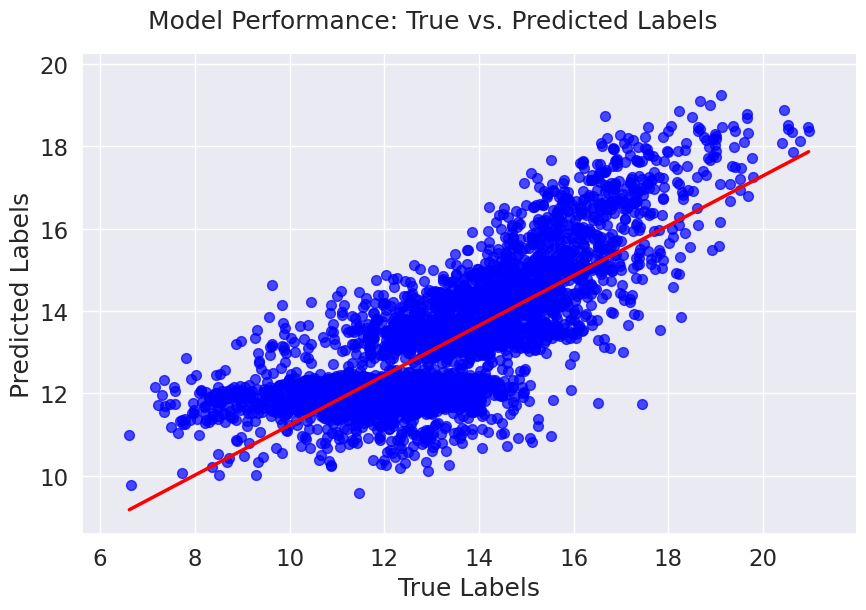

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

##Decision Tree

###Hyper-parameter Turning

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best HyperParameter:  {'max_depth': 10}
0.5709300135493164


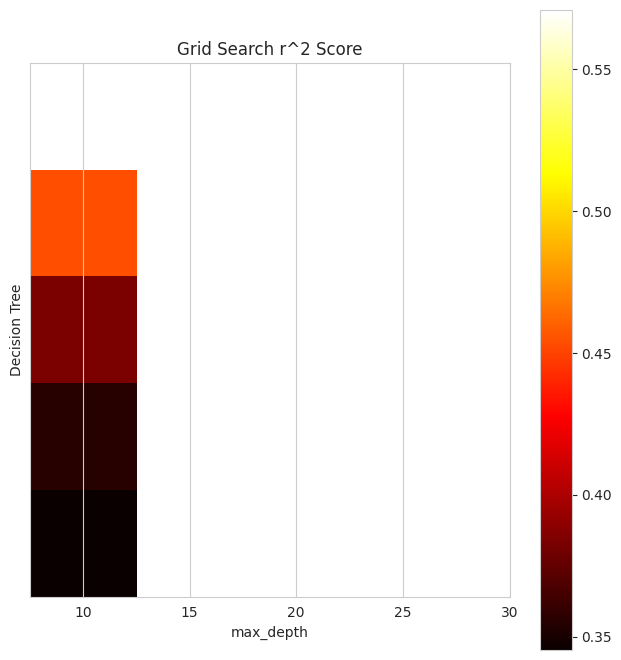

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

depth = [10, 15, 20, 25, 30]

DT = DecisionTreeRegressor()
hyperParam = [{'max_depth': depth}]
gsv = GridSearchCV(DT, hyperParam, cv=5, verbose=1, scoring='r2', n_jobs=-1)
gsv.fit(train, y_train)

print("Best HyperParameter: ", gsv.best_params_)
print(gsv.best_score_)

scores = gsv.cv_results_['mean_test_score'].reshape(-1, 1)
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('max_depth')
plt.ylabel('Decision Tree')
plt.colorbar()
plt.xticks(np.arange(len(depth)), depth)
plt.yticks([])
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
#10

###Decision Tree using Optimal Hyperparameter

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = DecisionTreeRegressor(max_depth=maxDepth) #10
model.fit(train, y_train)

# predicting the test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy:", model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data=d1)
print(SK)


RSME 1.255872421613654
R^2: 0.62
Accuracy: 0.6187367573934447
       True Labels  Predicted Labels
27568    13.564148         14.937583
14670    11.516290         11.916451
17541    17.114283         16.403726
22667    11.847839         11.953532
35193    11.721678         11.721919
...            ...               ...
30439    12.281278         11.721919
22450    12.867321         12.319139
57241    12.774923         12.140763
32627    12.174845         12.352925
8419     14.507467         16.899986

[4773 rows x 2 columns]


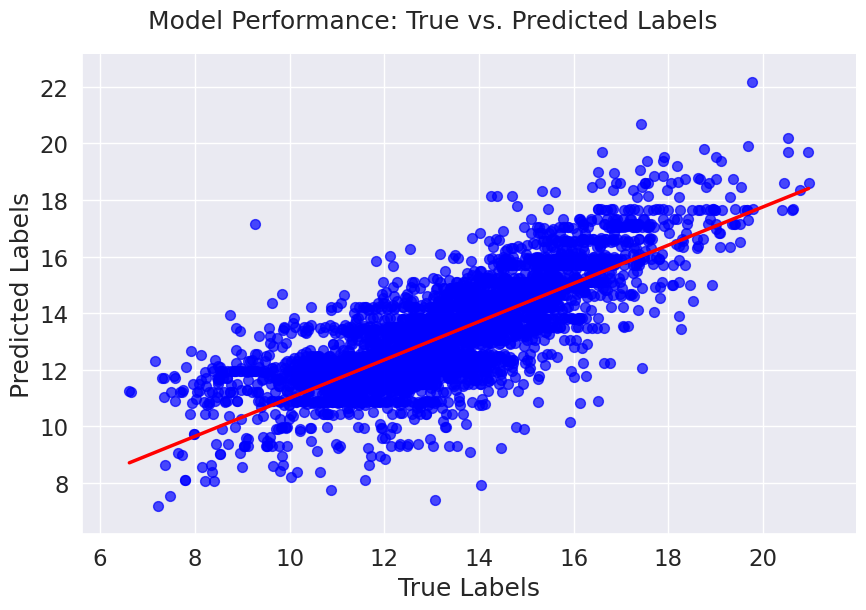

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

##Random Forest

###Hyper-parameter Turning

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best HyperParameter:  {'max_depth': 25, 'n_estimators': 200}
0.6811553603390648


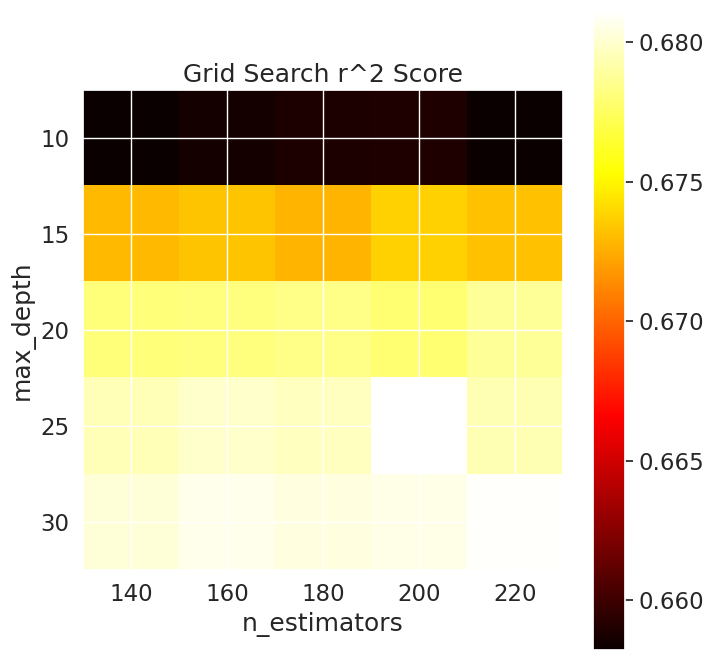

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
nEstimator = [140,160,180,200,220]
depth = [10,15,20,25,30]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='r2',n_jobs=-1)
gsv.fit(train, y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
nEstimators=gsv.best_params_['n_estimators']

#Best HyperParameter:  {'max_depth': 25, 'n_estimators': 200}

###Random Forest using Optimal Hyperparameter

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = nEstimators,max_depth=maxDepth)
model.fit(train, y_train)


# predicting the  test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy:",model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

RSME 1.0773864790349275
R^2: 0.72
Accuracy: 0.7194069357846757
       True Labels  Predicted Labels
27568    13.564148         14.676686
14670    11.516290         11.673477
17541    17.114283         16.391457
22667    11.847839         11.498926
35193    11.721678         11.591470
...            ...               ...
30439    12.281278         12.433613
22450    12.867321         12.764447
57241    12.774923         12.517661
32627    12.174845         12.047115
8419     14.507467         14.297133

[4773 rows x 2 columns]


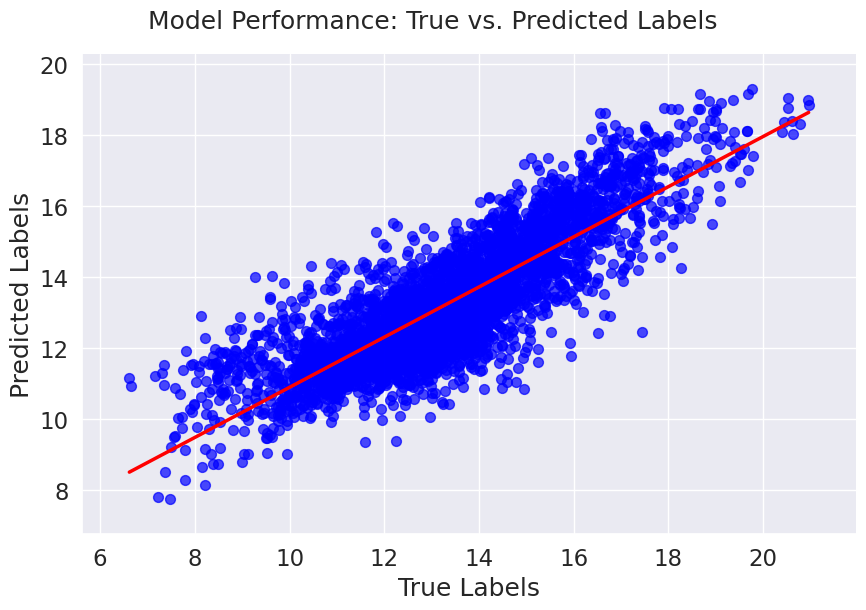

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

#Predict Log of Likes

In [ ]:
y_train = y_train_ft['likes_log']
y_test = y_test_ft['likes_log']
print(y_train.shape, y_test.shape)

(19091,) (4773,)


##Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(train, y_train)

# predicting the  test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy :",model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

RSME 1.676982181232461
R^2: 0.54
Accuracy : 0.5357985037393955
       True Labels  Predicted Labels
27568     7.533694          9.087669
14670     7.418781          7.357944
17541    13.418183         12.912701
22667     8.689296          7.956164
35193     8.796944          8.163360
...            ...               ...
30439     9.384126          8.596442
22450     8.958283          8.467082
57241     7.861727          7.845190
32627     8.874028          9.163147
8419      9.551587          7.676281

[4773 rows x 2 columns]


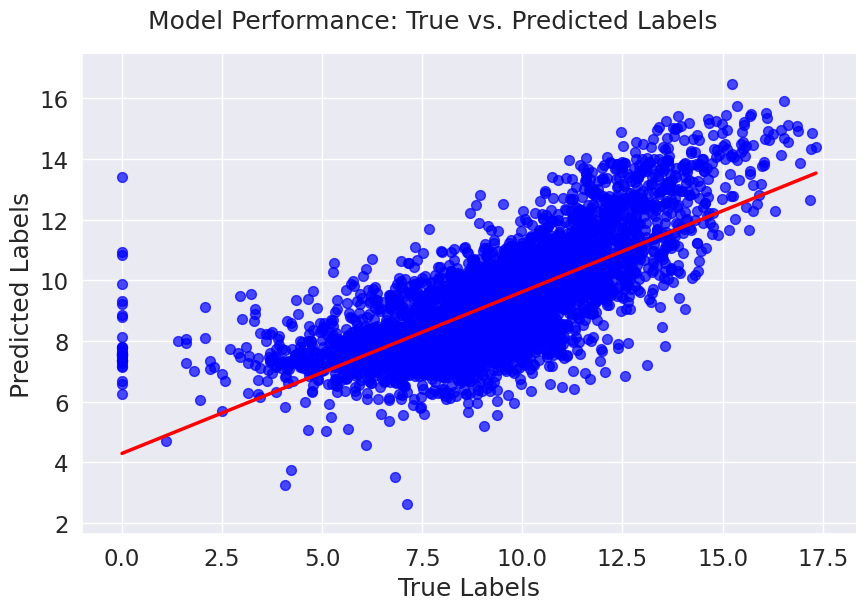

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

##Decision Tree

###Decision Tree using Optimal Hyperparameter

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best HyperParameter:  {'max_depth': 10}
0.4556818135874723


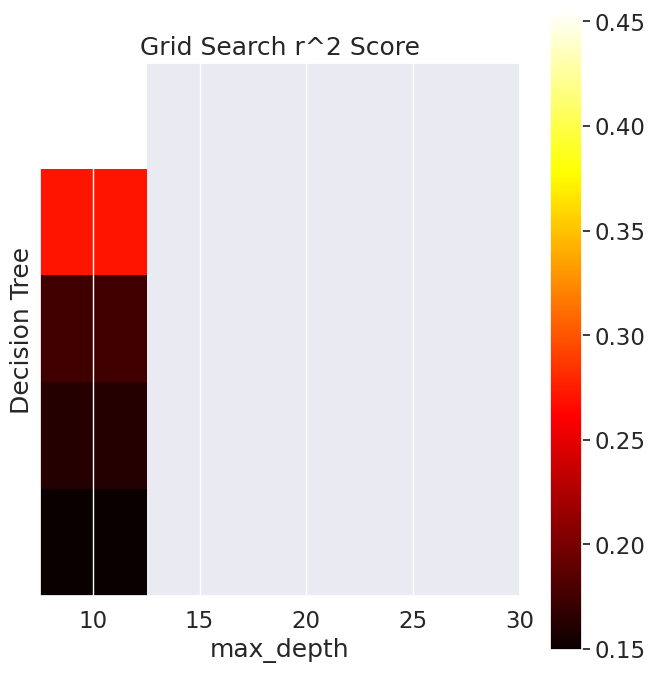

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

depth = [10, 15, 20, 25, 30]

DT = DecisionTreeRegressor()
hyperParam = [{'max_depth': depth}]
gsv = GridSearchCV(DT, hyperParam, cv=5, verbose=1, scoring='r2', n_jobs=1)
gsv.fit(train, y_train)

print("Best HyperParameter: ", gsv.best_params_)
print(gsv.best_score_)

scores = gsv.cv_results_['mean_test_score'].reshape(-1, 1)
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('max_depth')
plt.ylabel('Decision Tree')
plt.colorbar()
plt.xticks(np.arange(len(depth)), depth)
plt.yticks([])
plt.title('Grid Search r^2 Score')
plt.show()

###Decision Tree using Optimal Hyperparameter

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=maxDepth) #10
model.fit(train, y_train)

# predicting the test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy:", model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data=d1)
print(SK)

RSME 1.7347439292797602
R^2: 0.50
Accuracy: 0.5032699969957936
       True Labels  Predicted Labels
27568     7.533694          9.919336
14670     7.418781          7.757185
17541    13.418183         12.990391
22667     8.689296          6.996965
35193     8.796944          8.582251
...            ...               ...
30439     9.384126          9.720739
22450     8.958283          7.897390
57241     7.861727          2.591619
32627     8.874028         10.648125
8419      9.551587         10.734404

[4773 rows x 2 columns]


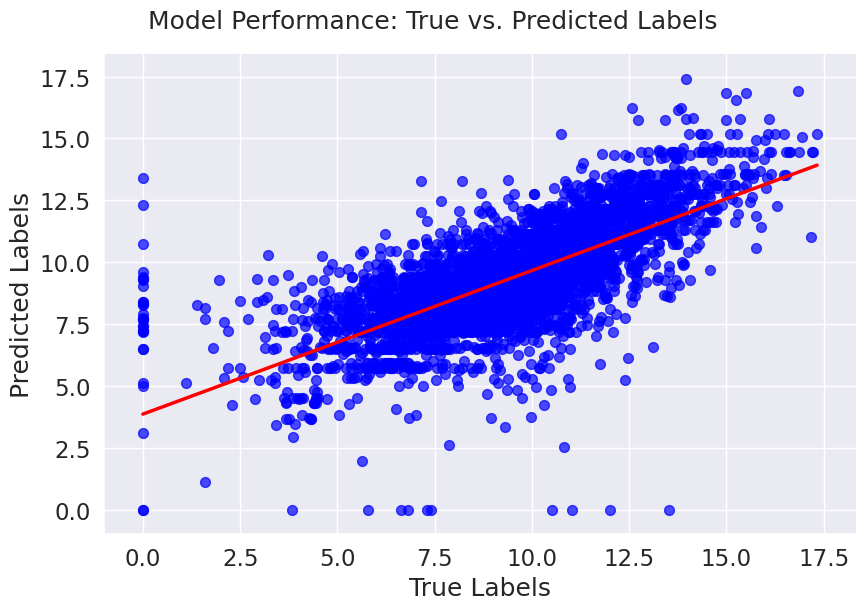

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

##Random Forest


###Hyper-parameter Turning

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best HyperParameter:  {'max_depth': 30, 'n_estimators': 220}
0.5893748672180925


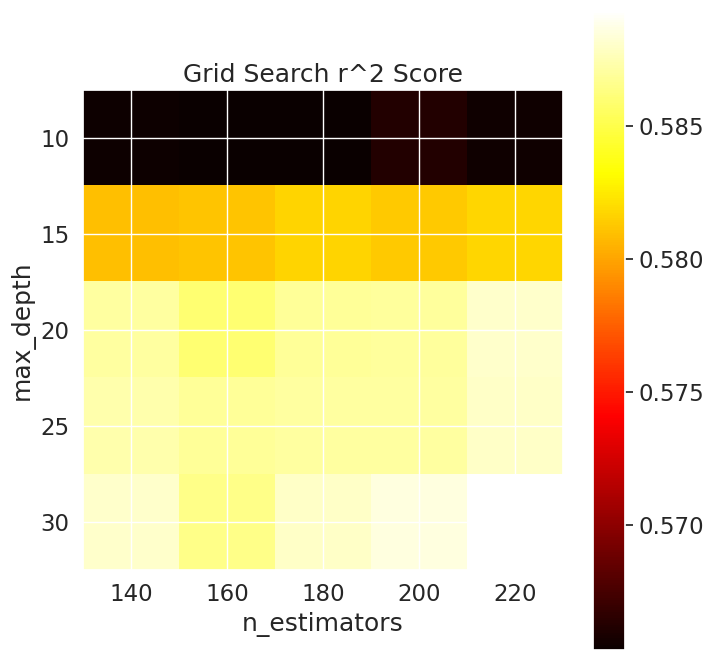

In [ ]:
from sklearn.ensemble import RandomForestRegressor

nEstimator = [140,160,180,200,220]
depth = [10,15,20,25,30]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF, hyperParam, cv=5, verbose=1, scoring='r2', n_jobs=1)
gsv.fit(train, y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
nEstimators=gsv.best_params_['n_estimators']

###Random Forest using Optimal Hyperparameter

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = nEstimators,max_depth=maxDepth)
model.fit(train, y_train)


# predicting the  test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy:",model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

RSME 1.4991836764175768
R^2: 0.63
Accuracy: 0.6290124549176661
       True Labels  Predicted Labels
27568     7.533694          9.494296
14670     7.418781          7.455820
17541    13.418183         11.634630
22667     8.689296          7.970101
35193     8.796944          8.570243
...            ...               ...
30439     9.384126          9.806591
22450     8.958283          8.543140
57241     7.861727          7.606616
32627     8.874028          8.285020
8419      9.551587         10.684111

[4773 rows x 2 columns]


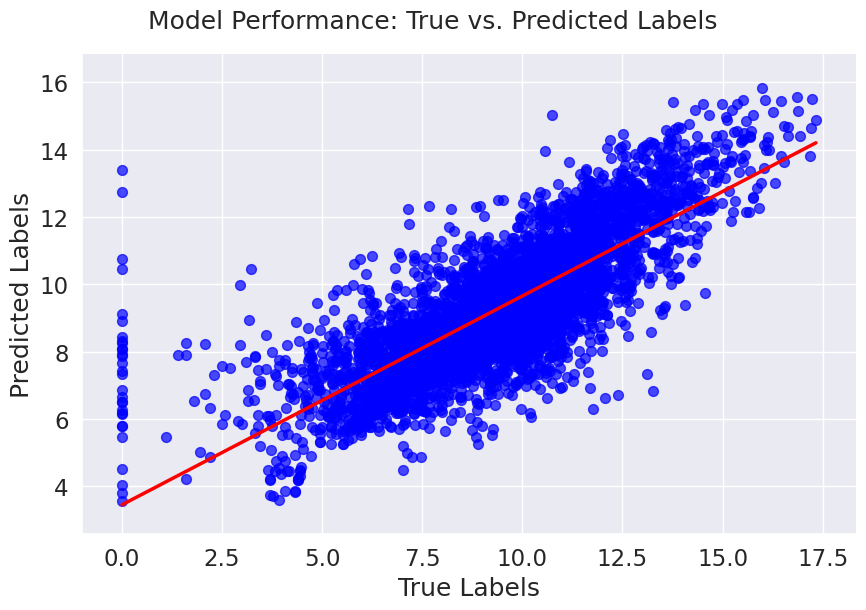

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

#Predict Log of Comment Counts

In [ ]:
y_train = y_train_ft['comment_log']
y_test = y_test_ft['comment_log']
print(y_train.shape, y_test.shape)

(19091,) (4773,)


##Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

model = LinearRegression()
model.fit(train, y_train)

# predicting the  test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy :",model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

RSME 1.6898025444565998
R^2: 0.47
Accuracy : 0.47104528986522964
       True Labels  Predicted Labels
27568     4.234107          7.065491
14670     5.837730          5.709123
17541    11.830193         10.502030
22667     5.384495          6.161221
35193     7.823246          6.339770
...            ...               ...
30439     7.331060          6.509276
22450     6.111467          6.663216
57241     4.770685          5.999437
32627     8.222554          7.408637
8419      6.838405          5.073894

[4773 rows x 2 columns]


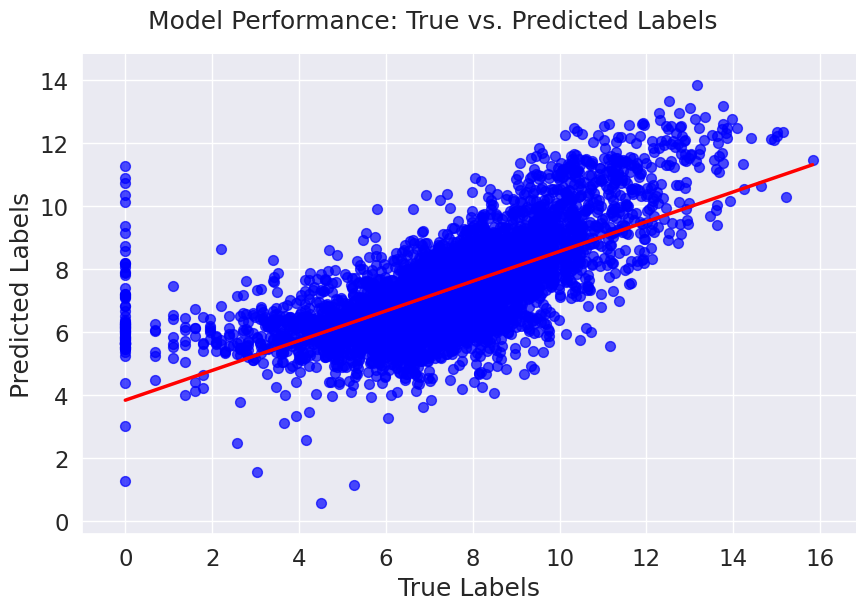

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

##Decision Tree

###Decision Tree using Optimal Hyperparameter

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best HyperParameter:  {'max_depth': 10}
0.3767905912978772


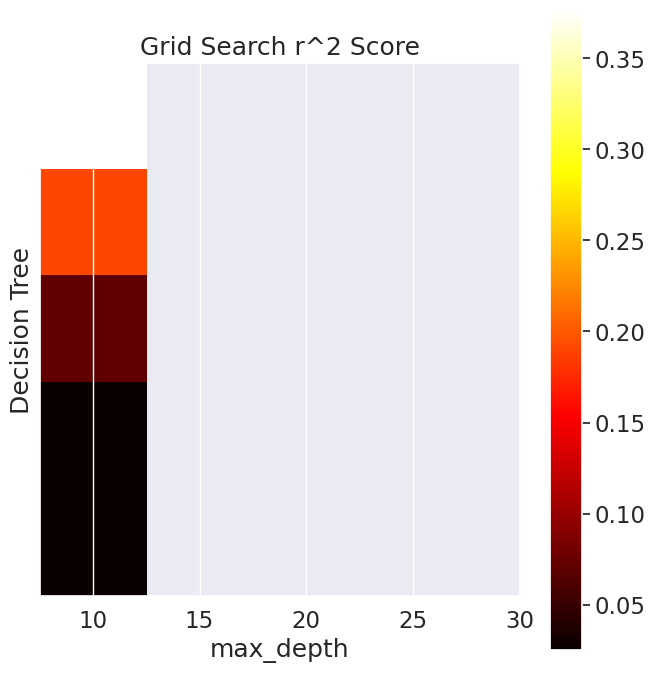

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

depth = [10, 15, 20, 25, 30]

DT = DecisionTreeRegressor()
hyperParam = [{'max_depth': depth}]
gsv = GridSearchCV(DT, hyperParam, cv=5, verbose=1, scoring='r2', n_jobs=1)
gsv.fit(train, y_train)

print("Best HyperParameter: ", gsv.best_params_)
print(gsv.best_score_)

scores = gsv.cv_results_['mean_test_score'].reshape(-1, 1)
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('max_depth')
plt.ylabel('Decision Tree')
plt.colorbar()
plt.xticks(np.arange(len(depth)), depth)
plt.yticks([])
plt.title('Grid Search r^2 Score')
maxDepth=gsv.best_params_['max_depth']

plt.show()

###Decision Tree using Optimal Hyperparameter

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=maxDepth) #10
model.fit(train, y_train)

# predicting the test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy:", model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data=d1)
print(SK)

RSME 1.7594800530364656
R^2: 0.43
Accuracy: 0.4265239772594108
       True Labels  Predicted Labels
27568     4.234107          7.238760
14670     5.837730          6.209276
17541    11.830193         10.773266
22667     5.384495          6.536046
35193     7.823246          6.922661
...            ...               ...
30439     7.331060          7.307488
22450     6.111467          6.948508
57241     4.770685          7.875667
32627     8.222554          6.381221
8419      6.838405          6.835619

[4773 rows x 2 columns]


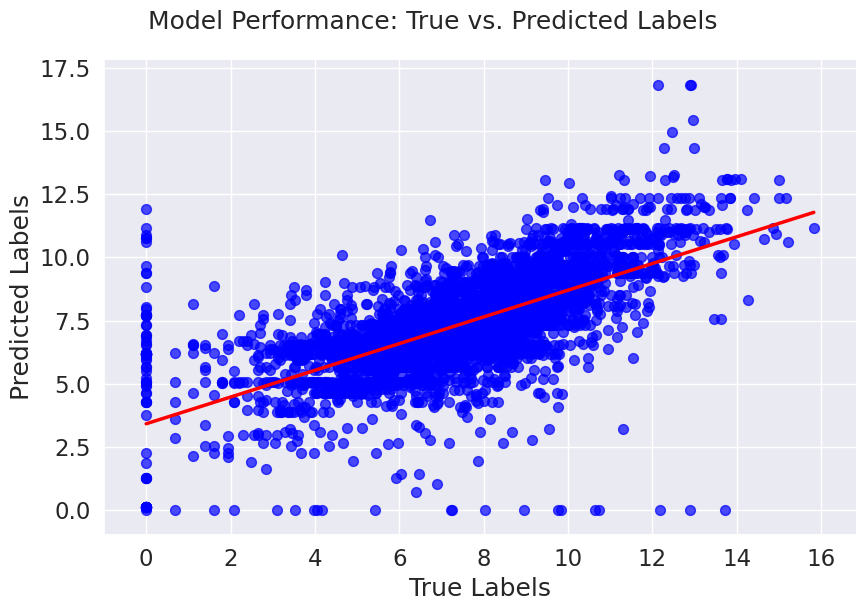

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

##Random Forest

###Hyper-parameter Turning

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best HyperParameter:  {'max_depth': 25, 'n_estimators': 220}
0.535149476522024


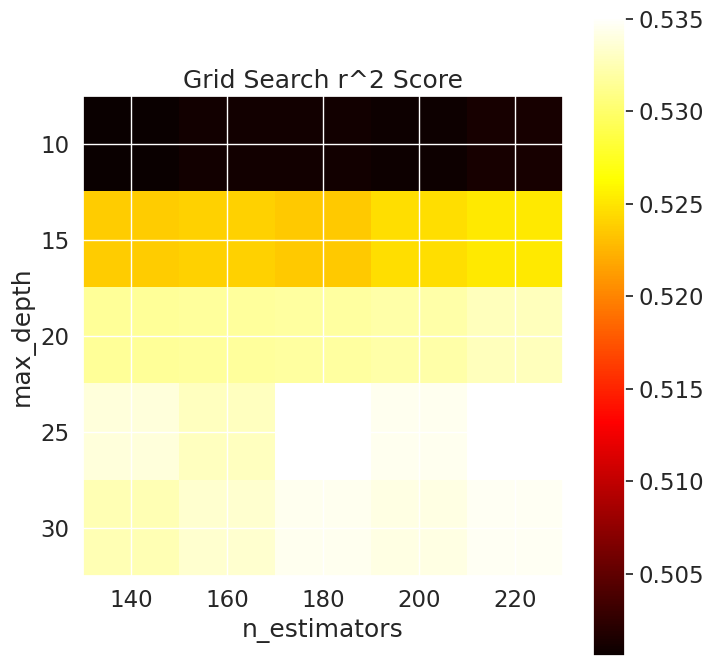

In [ ]:
from sklearn.ensemble import RandomForestRegressor

nEstimator = [140,160,180,200,220]
depth = [10,15,20,25,30]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF, hyperParam, cv=5, verbose=1, scoring='r2', n_jobs=1)
gsv.fit(train, y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))

plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
nEstimators=gsv.best_params_['n_estimators']

###Random Forest using Optimal Hyperparameter

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = nEstimators,max_depth=maxDepth)
model.fit(train, y_train)


# predicting the  test set results
y_pred = model.predict(test)
print('RMSE', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2: %.2f' % r2_score(y_test, y_pred))
print("Accuracy:",model.score(test, y_test))
d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}
SK = pd.DataFrame(data = d1)
print(SK)

RSME 1.491811739145508
R^2: 0.59
Accuracy: 0.5877367620819061
       True Labels  Predicted Labels
27568     4.234107          5.038791
14670     5.837730          6.028829
17541    11.830193          8.499542
22667     5.384495          5.678121
35193     7.823246          6.863275
...            ...               ...
30439     7.331060          7.812710
22450     6.111467          6.496672
57241     4.770685          5.623223
32627     8.222554          6.817511
8419      6.838405          6.587026

[4773 rows x 2 columns]


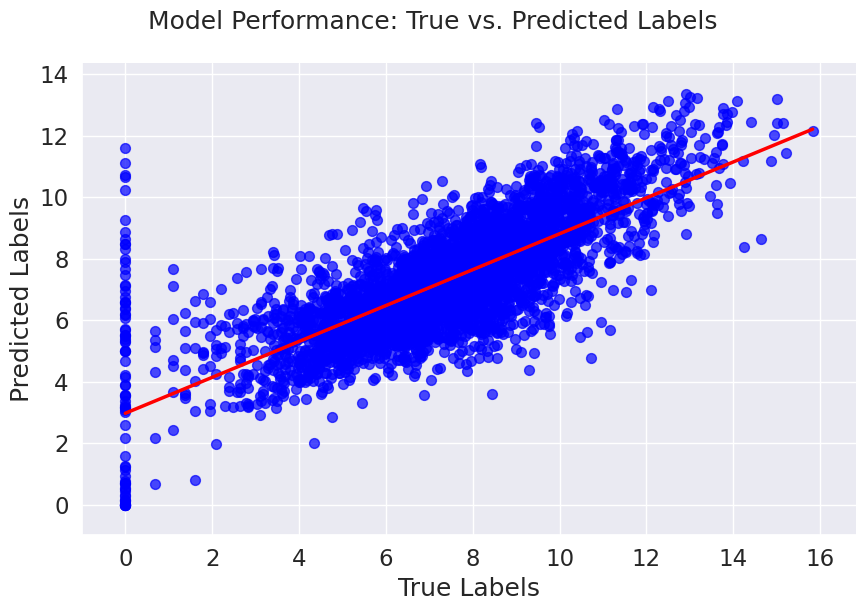

In [ ]:
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

# Create the lmplot with custom height and aspect ratio
lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data=SK, ci=10, height=6, aspect=1.5,
                 scatter_kws={"s": 50, "alpha": 0.7, "color": "blue"},
                 line_kws={"color": "red", "linewidth": 2.5})

# Set plot title and labels
lm1.fig.suptitle("Model Performance: True vs. Predicted Labels", fontsize=18, y=1.03)
lm1.set(xlabel="True Labels", ylabel="Predicted Labels")

# Set custom x and y limits
plt.xlim(min(SK["True Labels"])-1, max(SK["True Labels"]) +1)
plt.ylim(min(SK["Predicted Labels"]) -1, max(SK["Predicted Labels"]) +1)

# Show the plot
plt.show()

#Conclusion

### Log of Views Predicition

|Model|R^2|Accuracy|
|-----|--------|------|
|Linear Regression|0.61|0.614|
|Decision Tree|0.62|0.619|
|Random Forests|0.72|0.719|

### Log of Likes Predicition

|Model|R^2|Accuracy|
|-----|--------|------|
|Linear Regression|0.54|0.536|
|Decision Tree|0.50|0.503|
|Random Forests|0.63|0.629|


### Log of Comment Counts Prediction

|Model|R^2|Accuracy|
|-----|--------|------|
|Linear Regression|0.47|0.471|
|Decision Tree|0.43|0.427|
|Random Forests|0.59|0.588|


##Deploy the model

In [ ]:
import joblib

# save the model
joblib.dump(model, 'model.pkl')



['model.pkl']